## Creating Network-Based Profiles of Methylmalonyl-CoA Mutase Deficiency

Methylmalonic aciduria (MMA) is an inborn-error of metabolism classically caused by autosomal recessive mutations in ~20 genes which results in accumulation of methylmalonic acid.

To better understand the underlying pathogenesis of MMA, [Forny et. al., 2023](https://www.nature.com/articles/s42255-022-00720-8) profiled fibroblasts from 210 affected individuals and 20 controls using transcriptomics and proteomics.

To evaluate whether Napistu could be useful for characterizing the molecular biology and biochemistry of datasets like this, we sought to develop network-based signatures of MMA. This involves:

1. Loading the transcriptomics and proteomics datasets and formatting them as a [MuData object](https://mudata.readthedocs.io/en/latest/).
2. Log-transforming and filtering to well-measured features.
3. Normalization to row and column center the data, as per the original paper.
4. Performing exploratory data analysis to characterize the major patterns of variation in the datasets and how they relate to sample metadata attributes.
5. Creating molecular profiles containing sets of functionally-related transcripts & proteins.
    a. Our supervised approach involves fitting feature-wise regressions
    b. Our unsupervised approach involves using factor analysis to extra multiple correlated gene/protein expression programs. We can then regress these program usages on covariates of interest.
6. Bind each molecular profile to a Napistu network and harmonize the findings using personalized pagerank.

Before getting started we'll load packages and set global variables like paths.

In [1]:
import os

import anndata as ad
import matplotlib.pyplot as plt
from mudata import MuData
import pandas as pd

# import local modules
import processing
import profiles
import eda

In [2]:
SUPPLEMENTAL_DATA_DIR = os.path.expanduser("~/Desktop/Forny_2023_data")

SUPPLEMENTAL_DATA_FILES = {
    "transcriptomics" : {
        "file" : "42255_2022_720_MOESM3_ESM.xlsx",
        "sheet" : "Source Data transcriptomics"
    },
    "proteomics" : {
        "file" : "42255_2022_720_MOESM3_ESM.xlsx",
        "sheet" : "Source Data proteomics"
    },
    "phenotypes" : {
        "file" : "42255_2022_720_MOESM4_ESM.xlsx",
        "sheet" : 0
    }
}

# globals
# filter genes with fewer than this # of counts summed over samples
READ_CUTOFF = int(400)
ANALYSIS_LAYER = "log2_centered"
REGRESSION_FORMULA = "~ case + gender + 1"
FDR_CUTOFF = 0.1

Now, we can load the individual datasets as pd.DataFrames. I'm going to track these tables in a dict but its not really necessary.

In [3]:
# load
supplemental_data_path = {
    x : {
        "path" : os.path.join(SUPPLEMENTAL_DATA_DIR, y["file"]),
        "sheet" : y["sheet"]
    }
        for x, y in SUPPLEMENTAL_DATA_FILES.items()
}

assert all([os.path.isfile(x["path"]) for x in supplemental_data_path.values()])

supplemental_data = {
    x : pd.read_excel(y["path"], sheet_name = y["sheet"]) for x, y in supplemental_data_path.items()
}

In [4]:
# formatting
supplemental_data["transcriptomics"] = supplemental_data["transcriptomics"].rename({"Unnamed: 0" : "ensembl_gene"}, axis = 1).set_index("ensembl_gene")
supplemental_data["proteomics"] = supplemental_data["proteomics"].rename({"PG.ProteinAccessions" : "uniprot"}, axis = 1).set_index("uniprot")
supplemental_data["phenotypes"] = supplemental_data["phenotypes"].rename({"Unnamed: 0" : "patient_id"}, axis = 1).set_index("patient_id")

In [5]:
supplemental_data["transcriptomics"].head()

,MMA001,MMA002,MMA003,MMA004,MMA005,MMA006,MMA007,MMA008,MMA009,MMA010,...,MMA220,MMA222,MMA223,MMA224,MMA225,MMA226,MMA227,MMA228,MMA229,MMA230
ensembl_gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634,1.873615,1.505270,0.986076,1.123403,5.806861,1.431328,1.251731,9.403244,1.353007,1.174570,...,12.565674,5.229523,6.640500,3.129463,1.731466,1.518375,1.121370,1.922590,3.458497,0.989769
ENSG00000188976,13.627592,7.954398,7.072510,7.722724,11.079538,6.171506,6.466709,12.337651,11.094306,5.950285,...,17.705565,9.782707,9.526287,7.936750,6.794779,8.044985,7.041855,8.283558,11.754802,7.057638
ENSG00000187961,1.037994,0.552903,0.436914,0.738782,1.691288,0.438173,0.606665,0.985185,1.486020,0.152516,...,0.839992,0.810122,0.458880,0.343265,0.510889,0.270509,0.218708,0.439597,0.429895,0.604521
ENSG00000187583,0.698824,0.041128,0.024047,0.061751,0.238684,0.037082,0.019218,0.483886,0.058053,0.030468,...,0.862213,0.126554,0.429522,0.041436,0.042376,0.000000,0.076661,0.000000,0.012485,0.014054
ENSG00000187642,0.166474,0.403885,0.033554,0.083613,0.069547,0.042103,0.041908,0.117374,0.019715,0.007449,...,0.185598,0.027146,0.098651,0.000000,0.026749,0.000000,0.011748,0.000000,0.000000,0.023950


In [6]:
supplemental_data["transcriptomics"]

# i'm not sure what these units are - they don't look like counts (too many non-integers) and the col-sums are not constant across samples
# supplemental_data["transcriptomics"].sum(axis = 0).hist()

,MMA001,MMA002,MMA003,MMA004,MMA005,MMA006,MMA007,MMA008,MMA009,MMA010,...,MMA220,MMA222,MMA223,MMA224,MMA225,MMA226,MMA227,MMA228,MMA229,MMA230
ensembl_gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634,1.873615,1.505270,0.986076,1.123403,5.806861,1.431328,1.251731,9.403244,1.353007,1.174570,...,12.565674,5.229523,6.640500,3.129463,1.731466,1.518375,1.121370,1.922590,3.458497,0.989769
ENSG00000188976,13.627592,7.954398,7.072510,7.722724,11.079538,6.171506,6.466709,12.337651,11.094306,5.950285,...,17.705565,9.782707,9.526287,7.936750,6.794779,8.044985,7.041855,8.283558,11.754802,7.057638
ENSG00000187961,1.037994,0.552903,0.436914,0.738782,1.691288,0.438173,0.606665,0.985185,1.486020,0.152516,...,0.839992,0.810122,0.458880,0.343265,0.510889,0.270509,0.218708,0.439597,0.429895,0.604521
ENSG00000187583,0.698824,0.041128,0.024047,0.061751,0.238684,0.037082,0.019218,0.483886,0.058053,0.030468,...,0.862213,0.126554,0.429522,0.041436,0.042376,0.000000,0.076661,0.000000,0.012485,0.014054
ENSG00000187642,0.166474,0.403885,0.033554,0.083613,0.069547,0.042103,0.041908,0.117374,0.019715,0.007449,...,0.185598,0.027146,0.098651,0.000000,0.026749,0.000000,0.011748,0.000000,0.000000,0.023950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000099725,0.000000,0.000000,0.015544,0.369560,1.107666,0.425329,0.000000,0.000000,0.000000,0.000000,...,0.316457,0.005195,0.341058,0.453275,0.000000,0.366223,0.491734,0.417040,0.000000,0.557731
ENSG00000114374,0.000000,0.000000,0.000000,1.170908,1.894446,1.925946,0.000000,0.000000,0.000000,0.000000,...,2.240075,0.000000,1.166122,1.800749,0.000000,1.446769,2.278580,1.139112,0.001574,1.616639
ENSG00000067048,0.000000,0.000000,0.000000,7.852414,13.277866,18.192403,0.000000,0.000000,0.000000,0.000000,...,9.390433,0.000000,8.295066,12.885792,0.000000,7.398381,10.489536,3.742999,0.000000,8.186472


In [7]:
supplemental_data["proteomics"].head()

,PG.ProteinDescriptions,PG.ProteinNames,PG.Qvalue,MMA001,MMA002,MMA003,MMA004,MMA005,MMA006,MMA007,...,MMA221,MMA222,MMA223,MMA224,MMA225,MMA226,MMA227,MMA228,MMA229,MMA230
uniprot,,,,,,,,,,,,,,,,,,,,,
A0AVF1,Intraflagellar transport protein 56,IFT56_HUMAN,0.005996,83727.578125,119782.273438,435030.031250,351463.812500,473821.687500,462218.531250,461786.062500,...,96052.937500,203895.218750,367420.562500,128790.132812,258611.218750,236174.890625,281066.500000,57388.179688,21557.371094,165707.18750
A0AVT1,Ubiquitin-like modifier-activating enzyme 6,UBA6_HUMAN,0.000085,37115.953125,46101.957031,65014.164062,71438.554688,42789.007812,41797.777344,40118.589844,...,42814.156250,49667.570312,36617.558594,63397.425781,51176.625000,42973.957031,55355.019531,33448.113281,42359.183594,45239.43750
A0FGR8,Extended synaptotagmin-2,ESYT2_HUMAN,0.000017,40237.117188,217922.515625,197898.968750,122243.023438,152602.468750,170386.234375,158019.125000,...,160844.015625,131429.296875,147733.250000,130756.320312,181981.031250,110166.304688,131816.656250,139880.625000,199221.109375,108320.78125
A1AG_BOVINAlpha-1-acidglycoproteinOS=BostaurusGN=ORM1PE=2SV=1;CONT_Q3SZR3,;(Bos taurus) Alpha-1-acid glycoprotein precursor,NaN,0.000001,46269.468750,456155.343750,76156.734375,70375.281250,71832.406250,88579.406250,80614.843750,...,199413.093750,137026.562500,268573.125000,290260.312500,282464.937500,443858.531250,770606.937500,227444.343750,495527.593750,439083.68750
A1L0T0,Acetolactate synthase-like protein,ILVBL_HUMAN,0.000017,55125.847656,63051.160156,31387.976562,40272.636719,49587.910156,39840.132812,37784.460938,...,57427.914062,77553.562500,42669.714844,61045.855469,34615.488281,37323.367188,65609.390625,62056.046875,52899.207031,36870.06250


In [8]:
supplemental_data["phenotypes"].head()

,case,gender,n_passage,date_collection,date_freezing,consanguinity,onset_age,OHCblMinus,OHCblPlus,ratio,...,cssModif,irritability,hyperventilation,hypothermia,somnolence,vomiting,dehydration,feeding_problem,GFR,responsive_to_acute_treatment
patient_id,,,,,,,,,,,,,,,,,,,,,
MMA001,1,1,3.0,2001,2001,0,28.0,256.0,468.0,1.83,...,1,0,0,0,0,0,0,0,NaN,1
MMA002,1,1,3.0,2001,2001,1,1.0,1610.0,1544.0,0.96,...,2,0,0,0,0,0,1,1,NaN,0
MMA003,1,1,7.0,1991,1996,1,3.0,101.0,76.0,0.76,...,2,0,1,1,0,0,1,0,NaN,0
MMA004,1,0,5.0,1995,1996,0,3.0,220.0,219.0,1.00,...,2,0,0,0,0,0,0,0,NaN,1
MMA005,1,0,3.0,1995,1996,0,1.0,1830.0,1968.0,1.08,...,1,0,0,0,0,0,0,0,NaN,0


In [9]:
supplemental_data["phenotypes"].value_counts("case")

case
1    210
0     20
dtype: int64

## MuData Formatting

To make Napistu more accessible we'd like to lean more heavily on common data structures in genomics. One of these is the AnnData format and its extension to multiomic data MuData. AnnData objects can store lots of types of information, but at their core is observation- and feature-level metadata and a one or more data matrices.

Anndata results don't actually require an observation matrix, which is a nice feature for Napistu because for some results such as drug-screen results or QTLs the data would be better represented with feature attributes eschewing observation-level annoations.

In [10]:
transcr_adata = ad.AnnData(
    X = supplemental_data["transcriptomics"].T,
    # some samples are missing
    obs = supplemental_data["phenotypes"].loc[supplemental_data["phenotypes"].index.isin(supplemental_data["transcriptomics"].columns)],
    )

In [11]:
protein_metadata_vars = supplemental_data["proteomics"].columns[supplemental_data["proteomics"].columns.str.startswith("PG")]

proteomics_adata = ad.AnnData(
    # drop protein metadata vars and transpose
    X = supplemental_data["proteomics"].drop(protein_metadata_vars, axis = 1).T,
    # some samples are missing
    obs = supplemental_data["phenotypes"].loc[supplemental_data["phenotypes"].index.isin(supplemental_data["proteomics"].columns)],
    var = supplemental_data["proteomics"][protein_metadata_vars],
    )

In [12]:
mdata = MuData({"transcriptomics": transcr_adata, "proteomics": proteomics_adata})
mdata

/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/maya/Desktop/GITHUB/napistu/lib/napistu-scrapyard/applications/forny_2023/.venv/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 230 × 19537
  2 modalities
    transcriptomics:	221 x 14749
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_treatment'
    proteomics:	230 x 4788
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_treatment'
      var:	'PG.ProteinDescriptions', 'PG.ProteinNames', 'PG.Qvalue'

## Transformation and Normalization

Now that the datasets are incorporated in a AnnData/MuData objects we can manipulate them to in-place to make the data more Gaussian and to decrease the influence of non-biologicalop variation. 

From the paper, it sounds like the data was logged and normalization was approached by iteratively centering rows and columns until both were zero centered. Here, we'll try to follow the same logic.

### Filtering poorly measured features

First, we'll filter the RNAseq data since it includes some genes with very few reads.

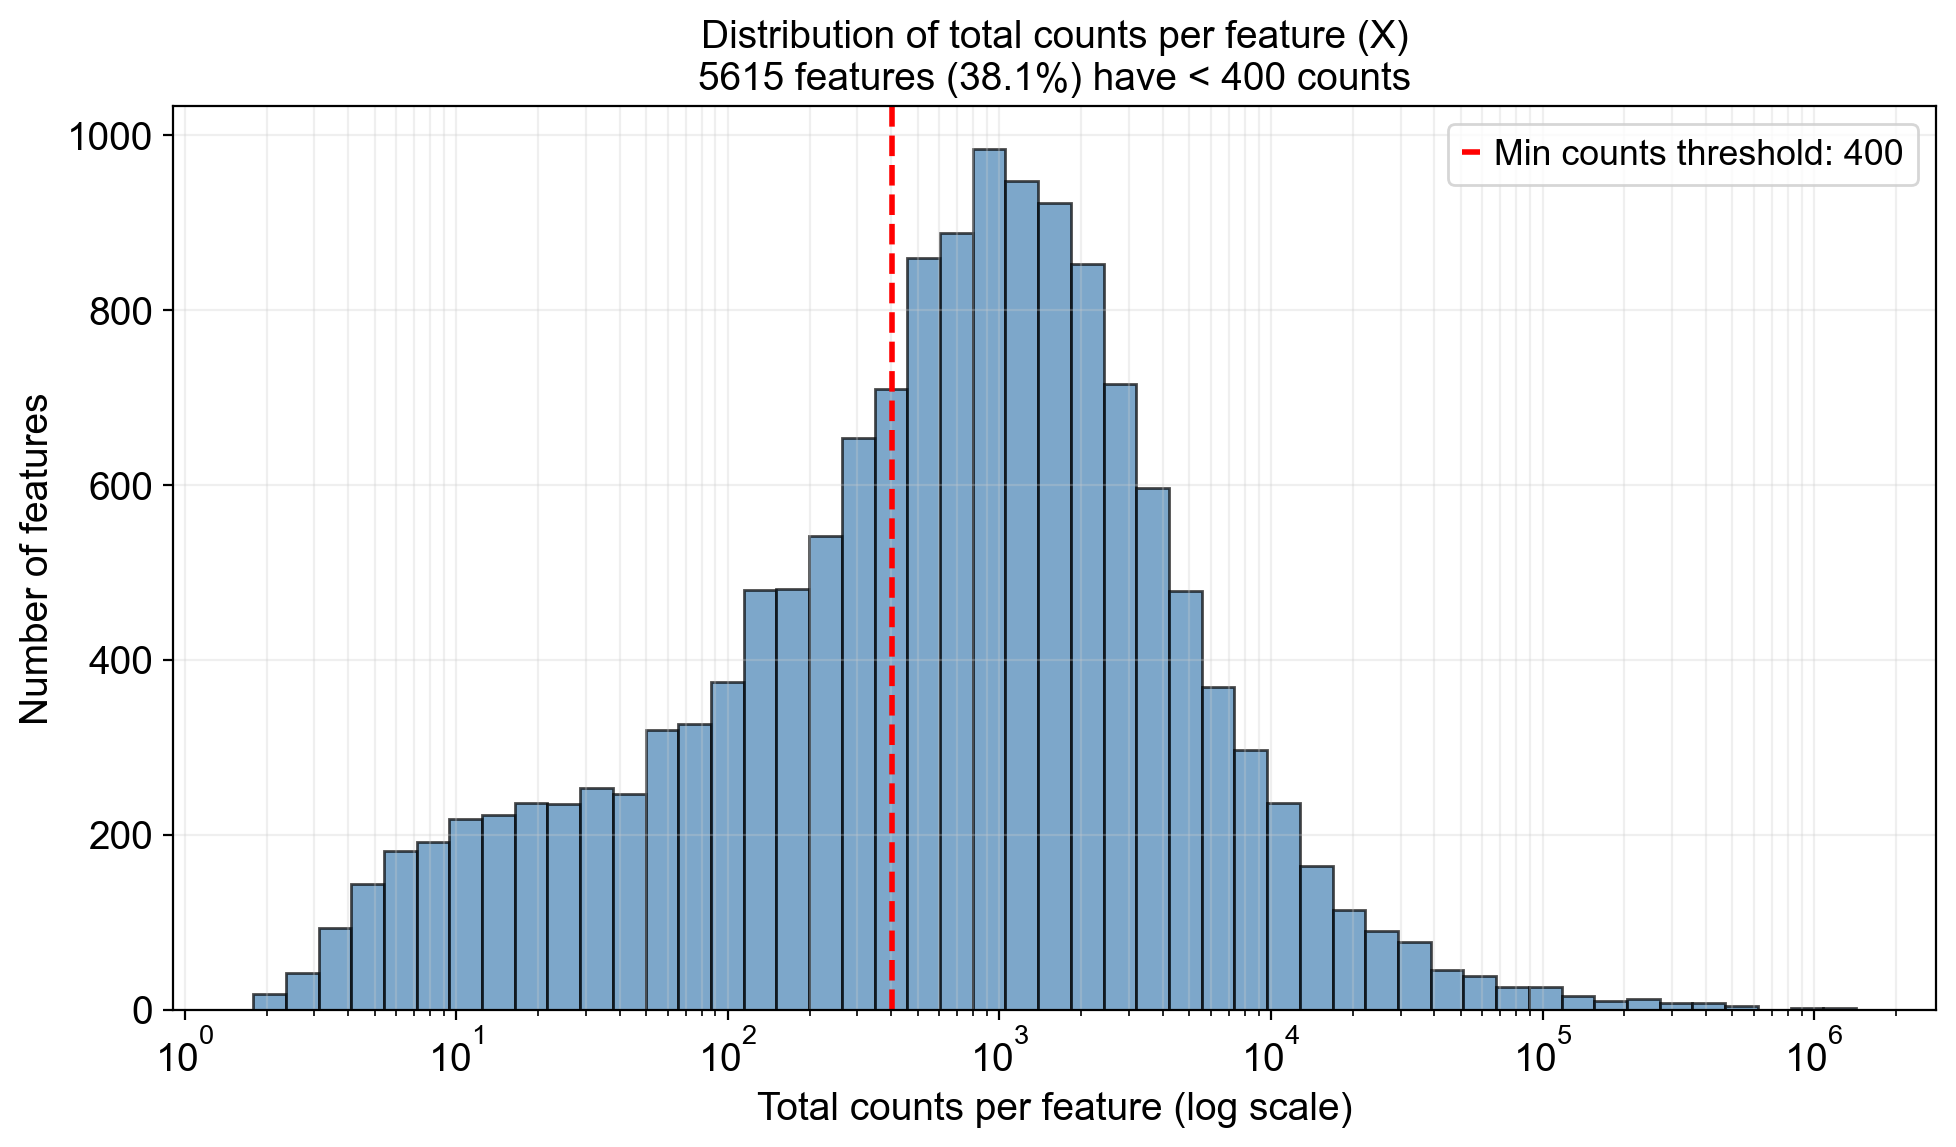

In [13]:
processing.plot_feature_counts_histogram(mdata["transcriptomics"], min_counts = READ_CUTOFF)
plt.show()

In [14]:
# filter to drop features with low counts
processing.filter_features_by_counts(mdata["transcriptomics"], min_counts = READ_CUTOFF)

## Log-transformation

Plot out some of the features they look pretty darn log-Normal and this generally a fair assumption for transcript- or protein-level data.

In [15]:
# add a pseudocount before logging
processing.log2_transform(mdata["transcriptomics"], pseudocount = 1)
# proteomics has a minimum value of 1 so no pseudocounts are needed before logging
processing.log2_transform(mdata["proteomics"], pseudocount = 0)

### Normalization

Apply iterative row and column centering as-per Forny et al., 2023.

In [16]:
processing.center_rows_and_columns_mudata(
    mdata,
    layer = "log2",
    new_layer_name = "log2_centered"
)

In [17]:
mdata

MuData object with n_obs × n_vars = 230 × 19537
  2 modalities
    transcriptomics:	221 x 9134
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_treatment'
      uns:	'feature_filtering', 'log2_transform'
      layers:	'log2', 'log2_centered'
    proteomics:	230 x 4788
      obs:	'case', 'gender', 'n_passage', 'date_collection', 'date_freezing', 'consanguinity', 'onset_age', 'OHCblMinus', 'OHCblPlus', 'ratio', 'SimultOHCblMinus', 'SimultOHCblPlus', 'mut_category', 'AdoCblMinus', 'AdoCblPlus', 'SimultAdoCblMinus', 'SimultAdoCblPlus', 'wgs_zygosity', 'prot_mut_level', 'rnaseq_mut_level', 'acidosis', 'metabolic_acidosis', 'metabolic_ketoacidosis', 'ketosis', 'hyperammonemia', 'abnormal_muscle_tone', 'musc_hypotonia', 'musc_hypertonia', 'fct_respiratory_abnormality', 'dyspnea', 'tachypnea', 'reduced_consciousness', 'lethargy', 'coma', 'seizures', 'general_tonic_clonic_seizure', 'any_GI_problem', 'failure_to_thrive', 'any_delay', 'behavioral_abnormality', 'concurrent_infection', 'MMA_urine', 'MMA_plasma', 'ammonia_umolL', 'pH', 'base_excess', 'pCO2', 'glucose_mmolL', 'urine_ketones', 'dialysis', 'peritoneal_dialysis', 'insulin', 'diet', 'carnitine', 'cobalamin', 'bicarb', 'glucose_IV', 'cobalamin_responsive', 'MMA_urine_after_treat', 'cobalamin_dose_PO', 'cobalamin_dose_IM', 'carnitine_dose', 'antibiotic_treatment', 'protein_restriction', 'natural_protein_amount', 'synthetic_protein_amount', 'total_protein_amount', 'meals_per_day', 'calories_per_day', 'tube_feeding_day', 'tube_feeding_night', 'tube_feeding_overall', 'weight_centile_quant', 'length_centile_quant', 'head_circumfernce_quant', 'language_delay', 'IQ', 'any_neurological_abnormalities_chronic', 'impaired_kidney_fct', 'uric_acid', 'creatinine', 'urea', 'hemat_abnormality', 'anemia', 'neutropenia', 'skin_abnormalities', 'hearing_impairment', 'osteoporosis', 'failure_to_thrive_chronic', 'cCSS', 'global_dev_delay_chr', 'hypotonia_chr', 'basal_ganglia_abnormality_chr', 'nCSSonlyNeuro', 'failure_to_thrive_or_tube_feeding', 'cssModif', 'irritability', 'hyperventilation', 'hypothermia', 'somnolence', 'vomiting', 'dehydration', 'feeding_problem', 'GFR', 'responsive_to_acute_trea

## Exploratory Data Analysis

Before digging into the results of the study its a good idea to understand the major factors driving the studies variation. Ideally, these are the variables of interest (i.e, case) but to the extent this is not true then we may have to add additional covariates or hunt for batch effects. Its also a good idea to generate a scree plot to see whether the variation is driven by a few known or unknown variables or if there are many sources of variation. Since this study has a large number of patient-derived samples I'm guessing we're in the latter scenario.

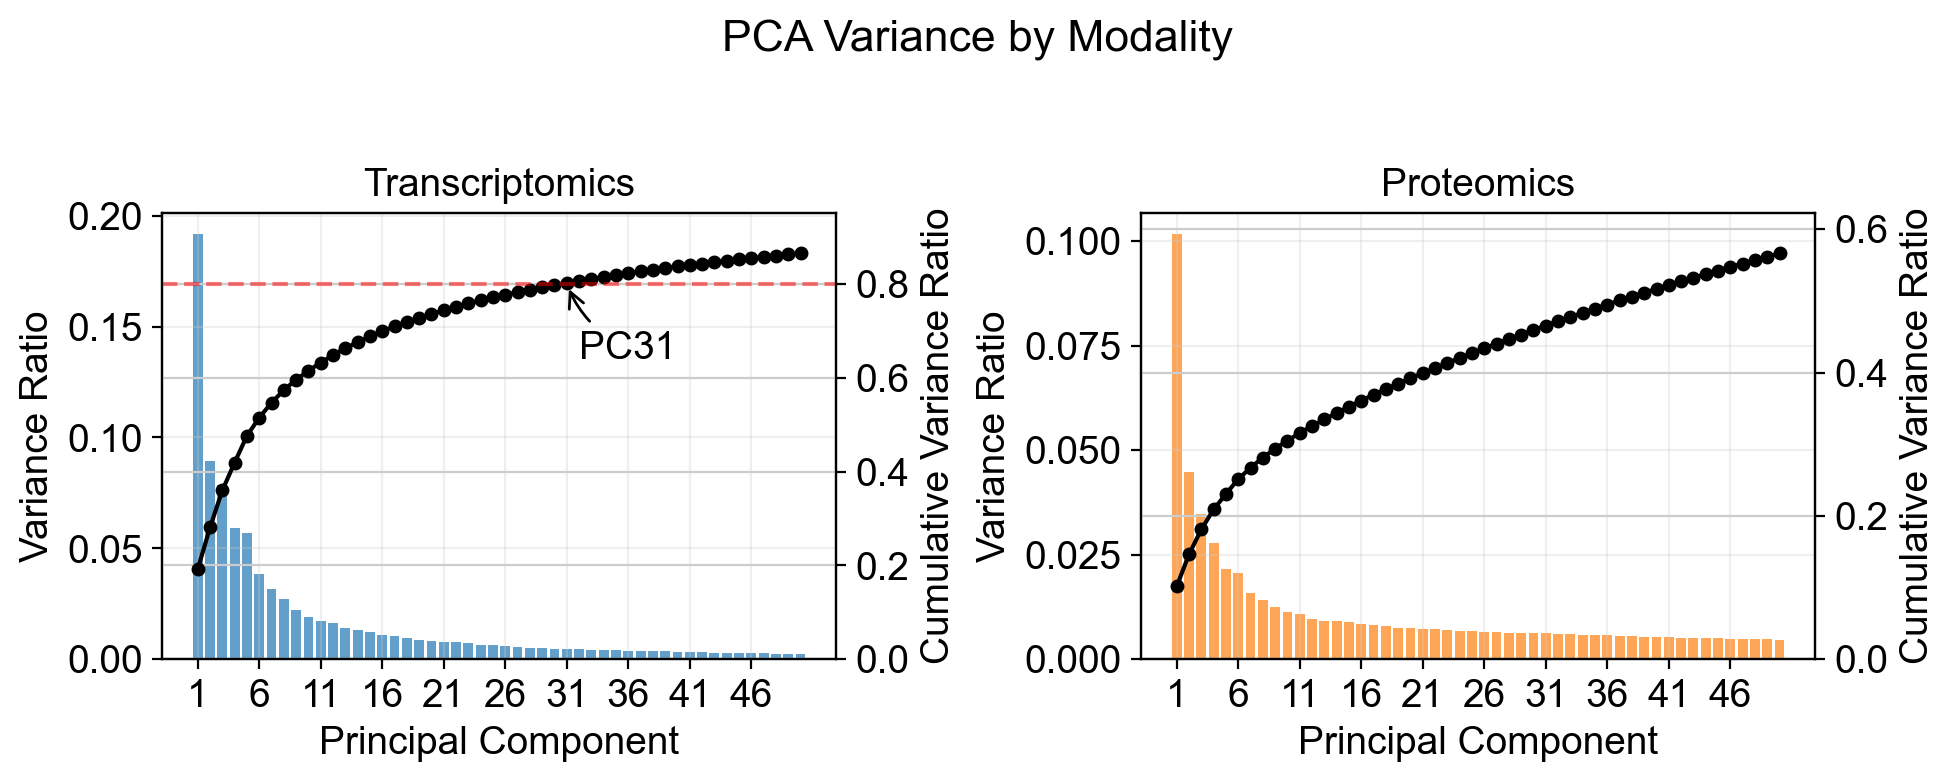

In [18]:
import scanpy as sc

# Process each modality
for modality in ['transcriptomics', 'proteomics']:
    # add PCs
    sc.pp.pca(mdata[modality], layer = ANALYSIS_LAYER)
    
eda.plot_mudata_pca_variance(mdata, n_pcs = int(50))
plt.show()

Filtering out 'MMA_plasma': only 4.5% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_PO': only 10.9% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_IM': only 10.9% non-missing values (threshold: 50%)
Filtering out 'carnitine_dose': only 29.0% non-missing values (threshold: 50%)
Filtering out 'synthetic_protein_amount': only 17.2% non-missing values (threshold: 50%)
Filtering out 'meals_per_day': only 17.6% non-missing values (threshold: 50%)
Filtering out 'IQ': only 2.3% non-missing values (threshold: 50%)
Filtering out 'urea': only 2.7% non-missing values (threshold: 50%)
Filtering out 'GFR': only 2.7% non-missing values (threshold: 50%)
Filtering out 'MMA_plasma': only 4.3% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_PO': only 11.7% non-missing values (threshold: 50%)
Filtering out 'cobalamin_dose_IM': only 10.9% non-missing values (threshold: 50%)
Filtering out 'carnitine_dose': only 29.6% non-missing values (threshold: 50%

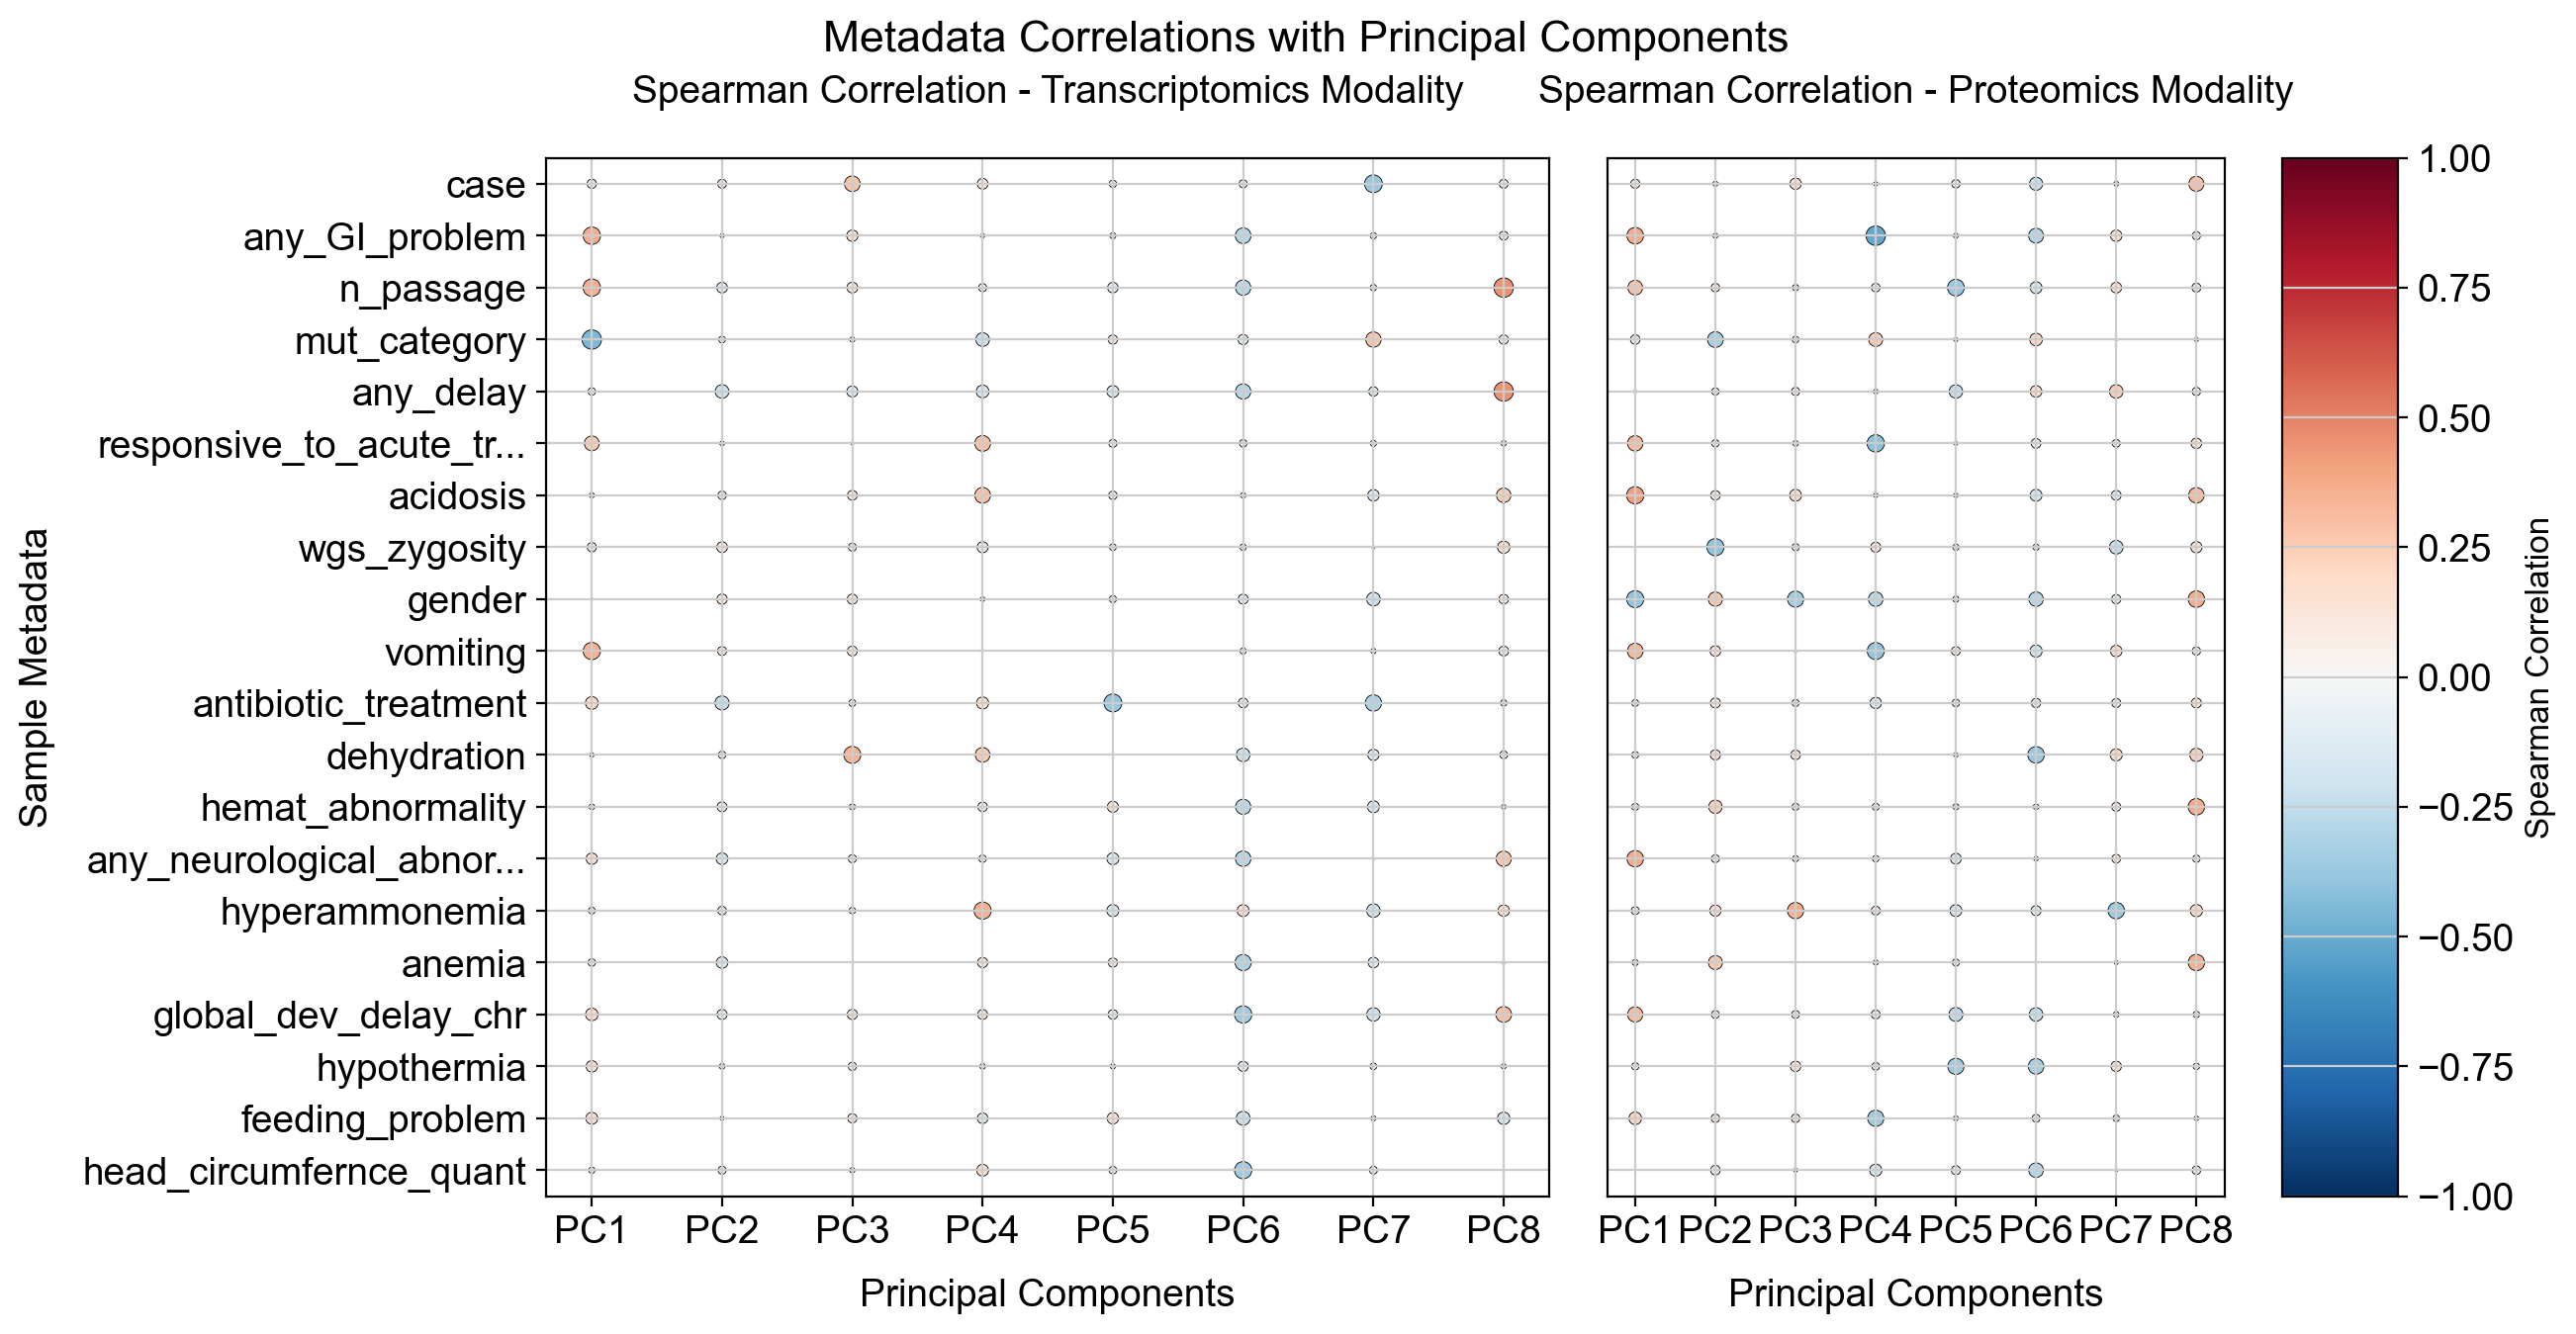

In [19]:

results = eda.analyze_pc_metadata_correlation_mudata(
    mdata,
    n_pcs=8,
    prioritized_vars=['case'],  # This will always show 'case' variable at the top
    pca_kwargs={'svd_solver': 'arpack'},
    
    figsize = (12, 7)
)

plt.show()

Processing transcriptomics modality...
Processing proteomics modality...


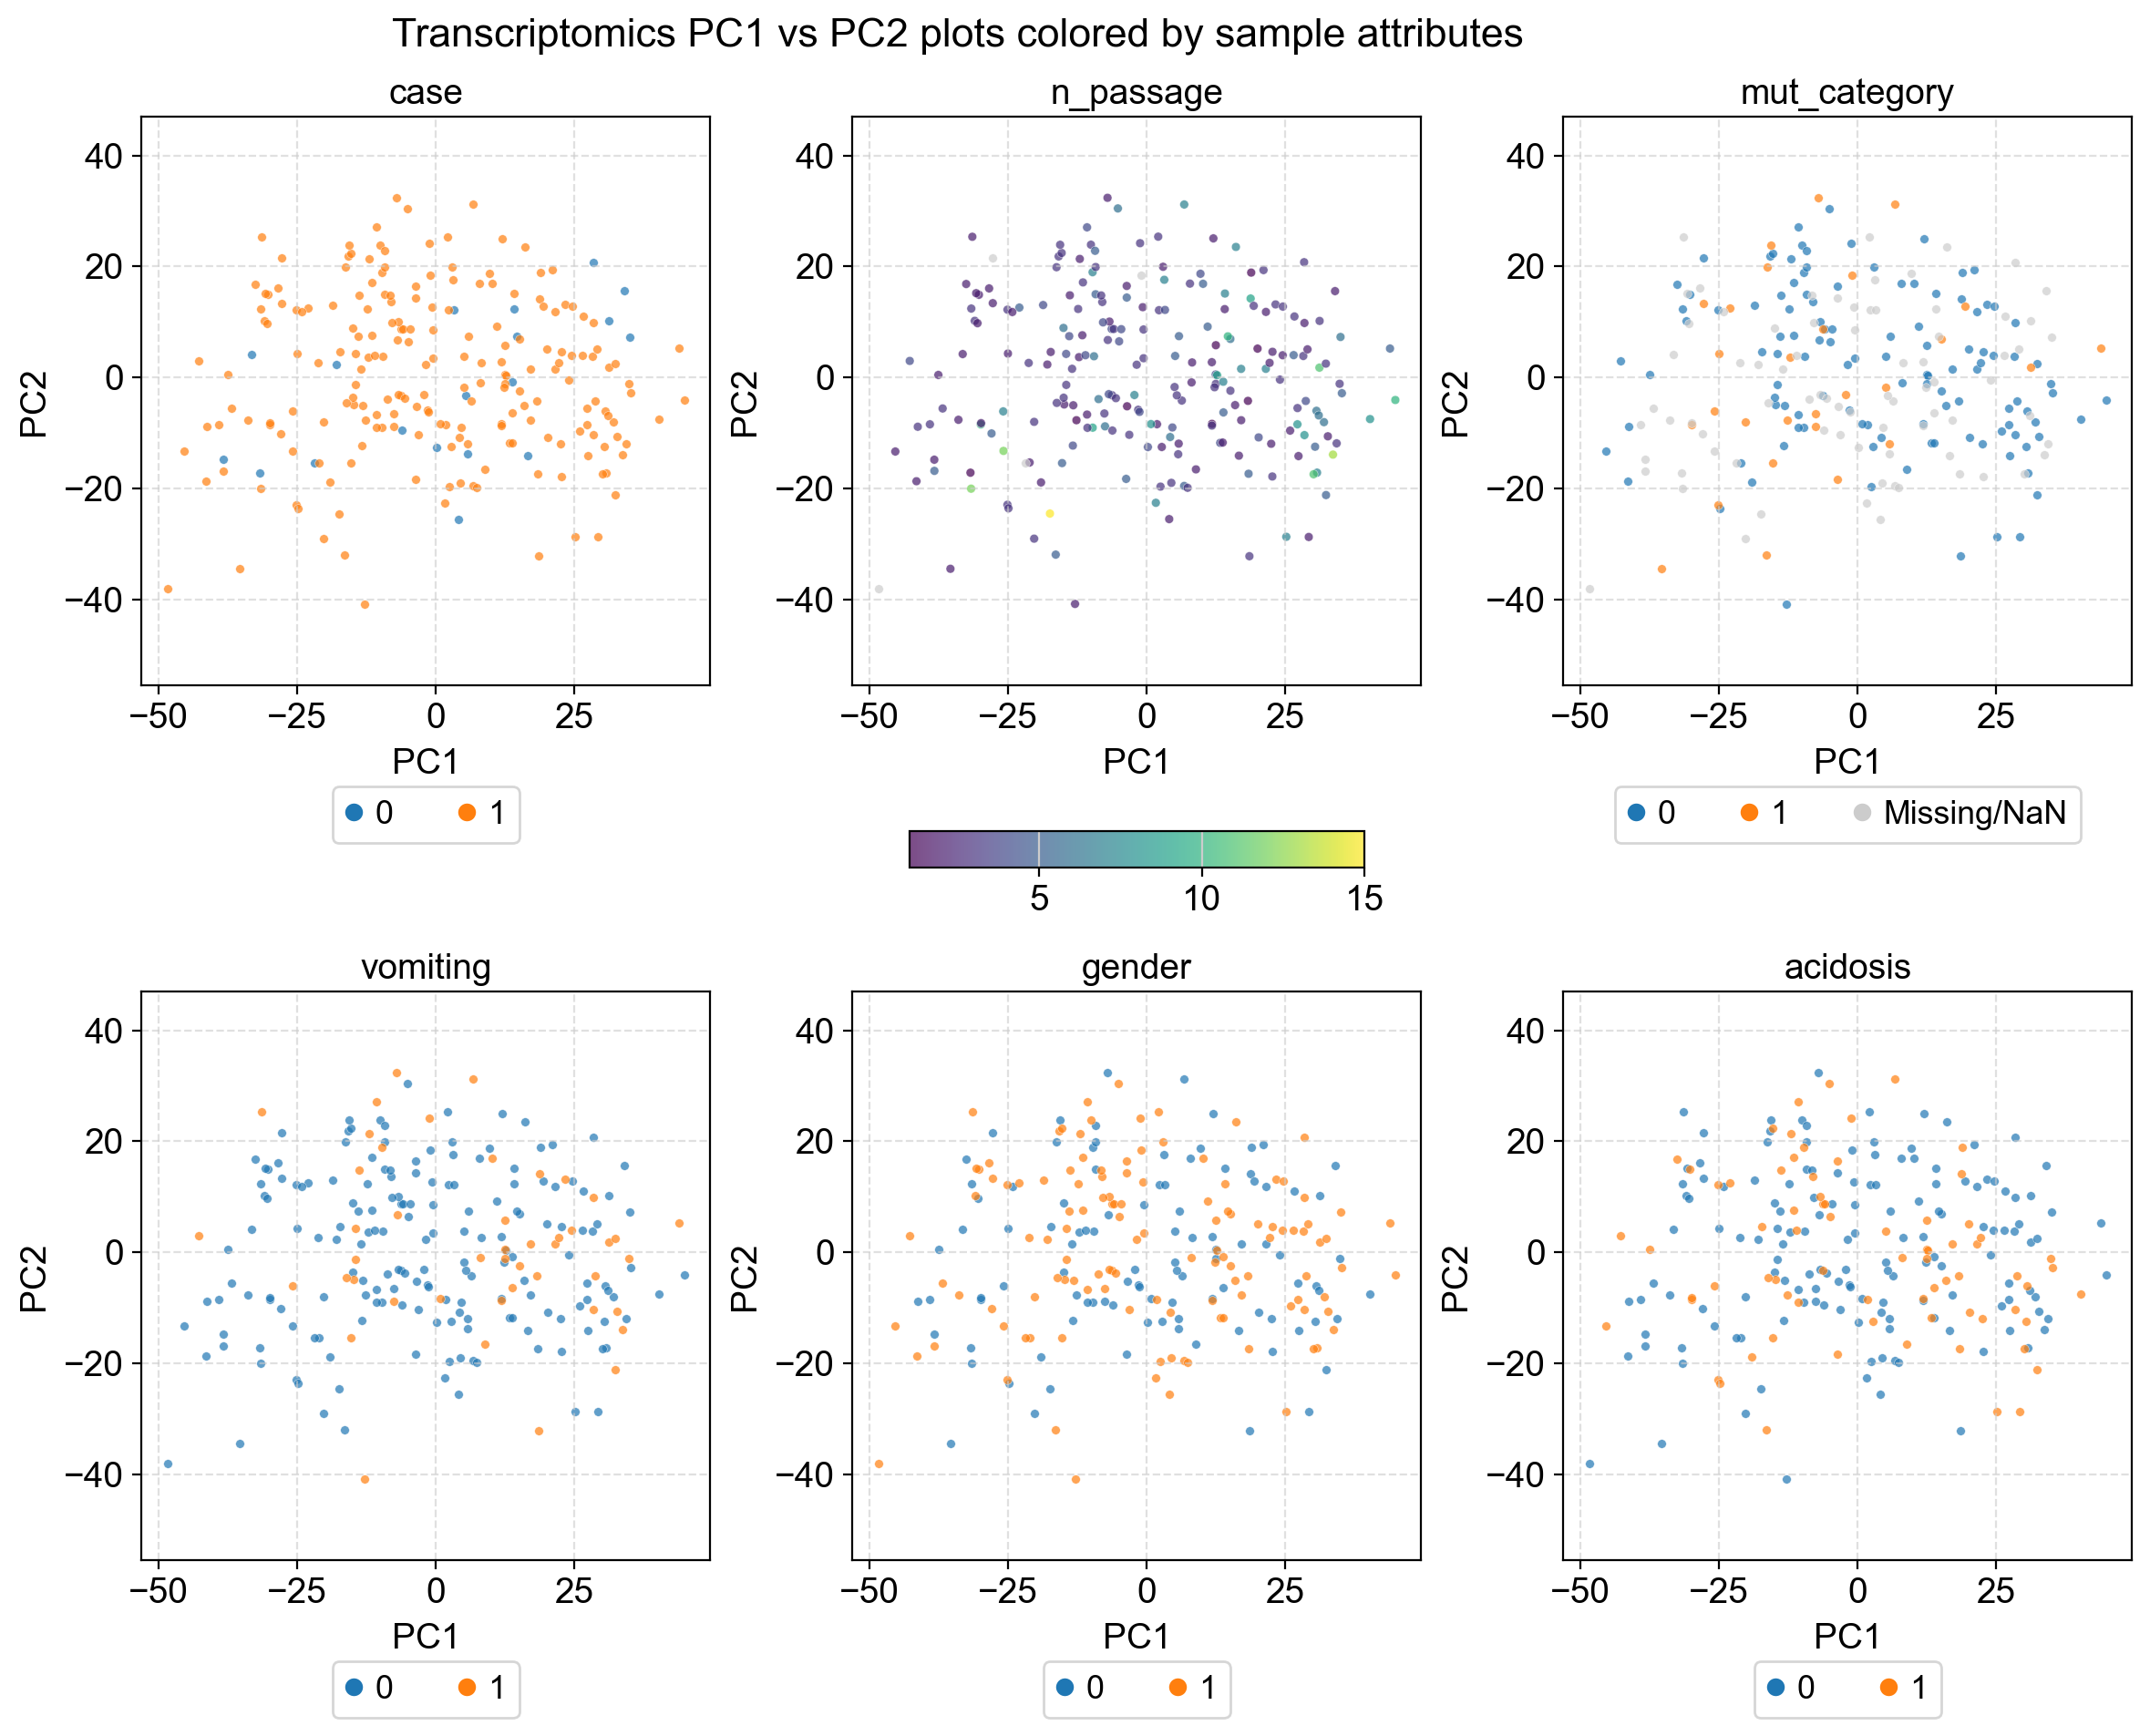

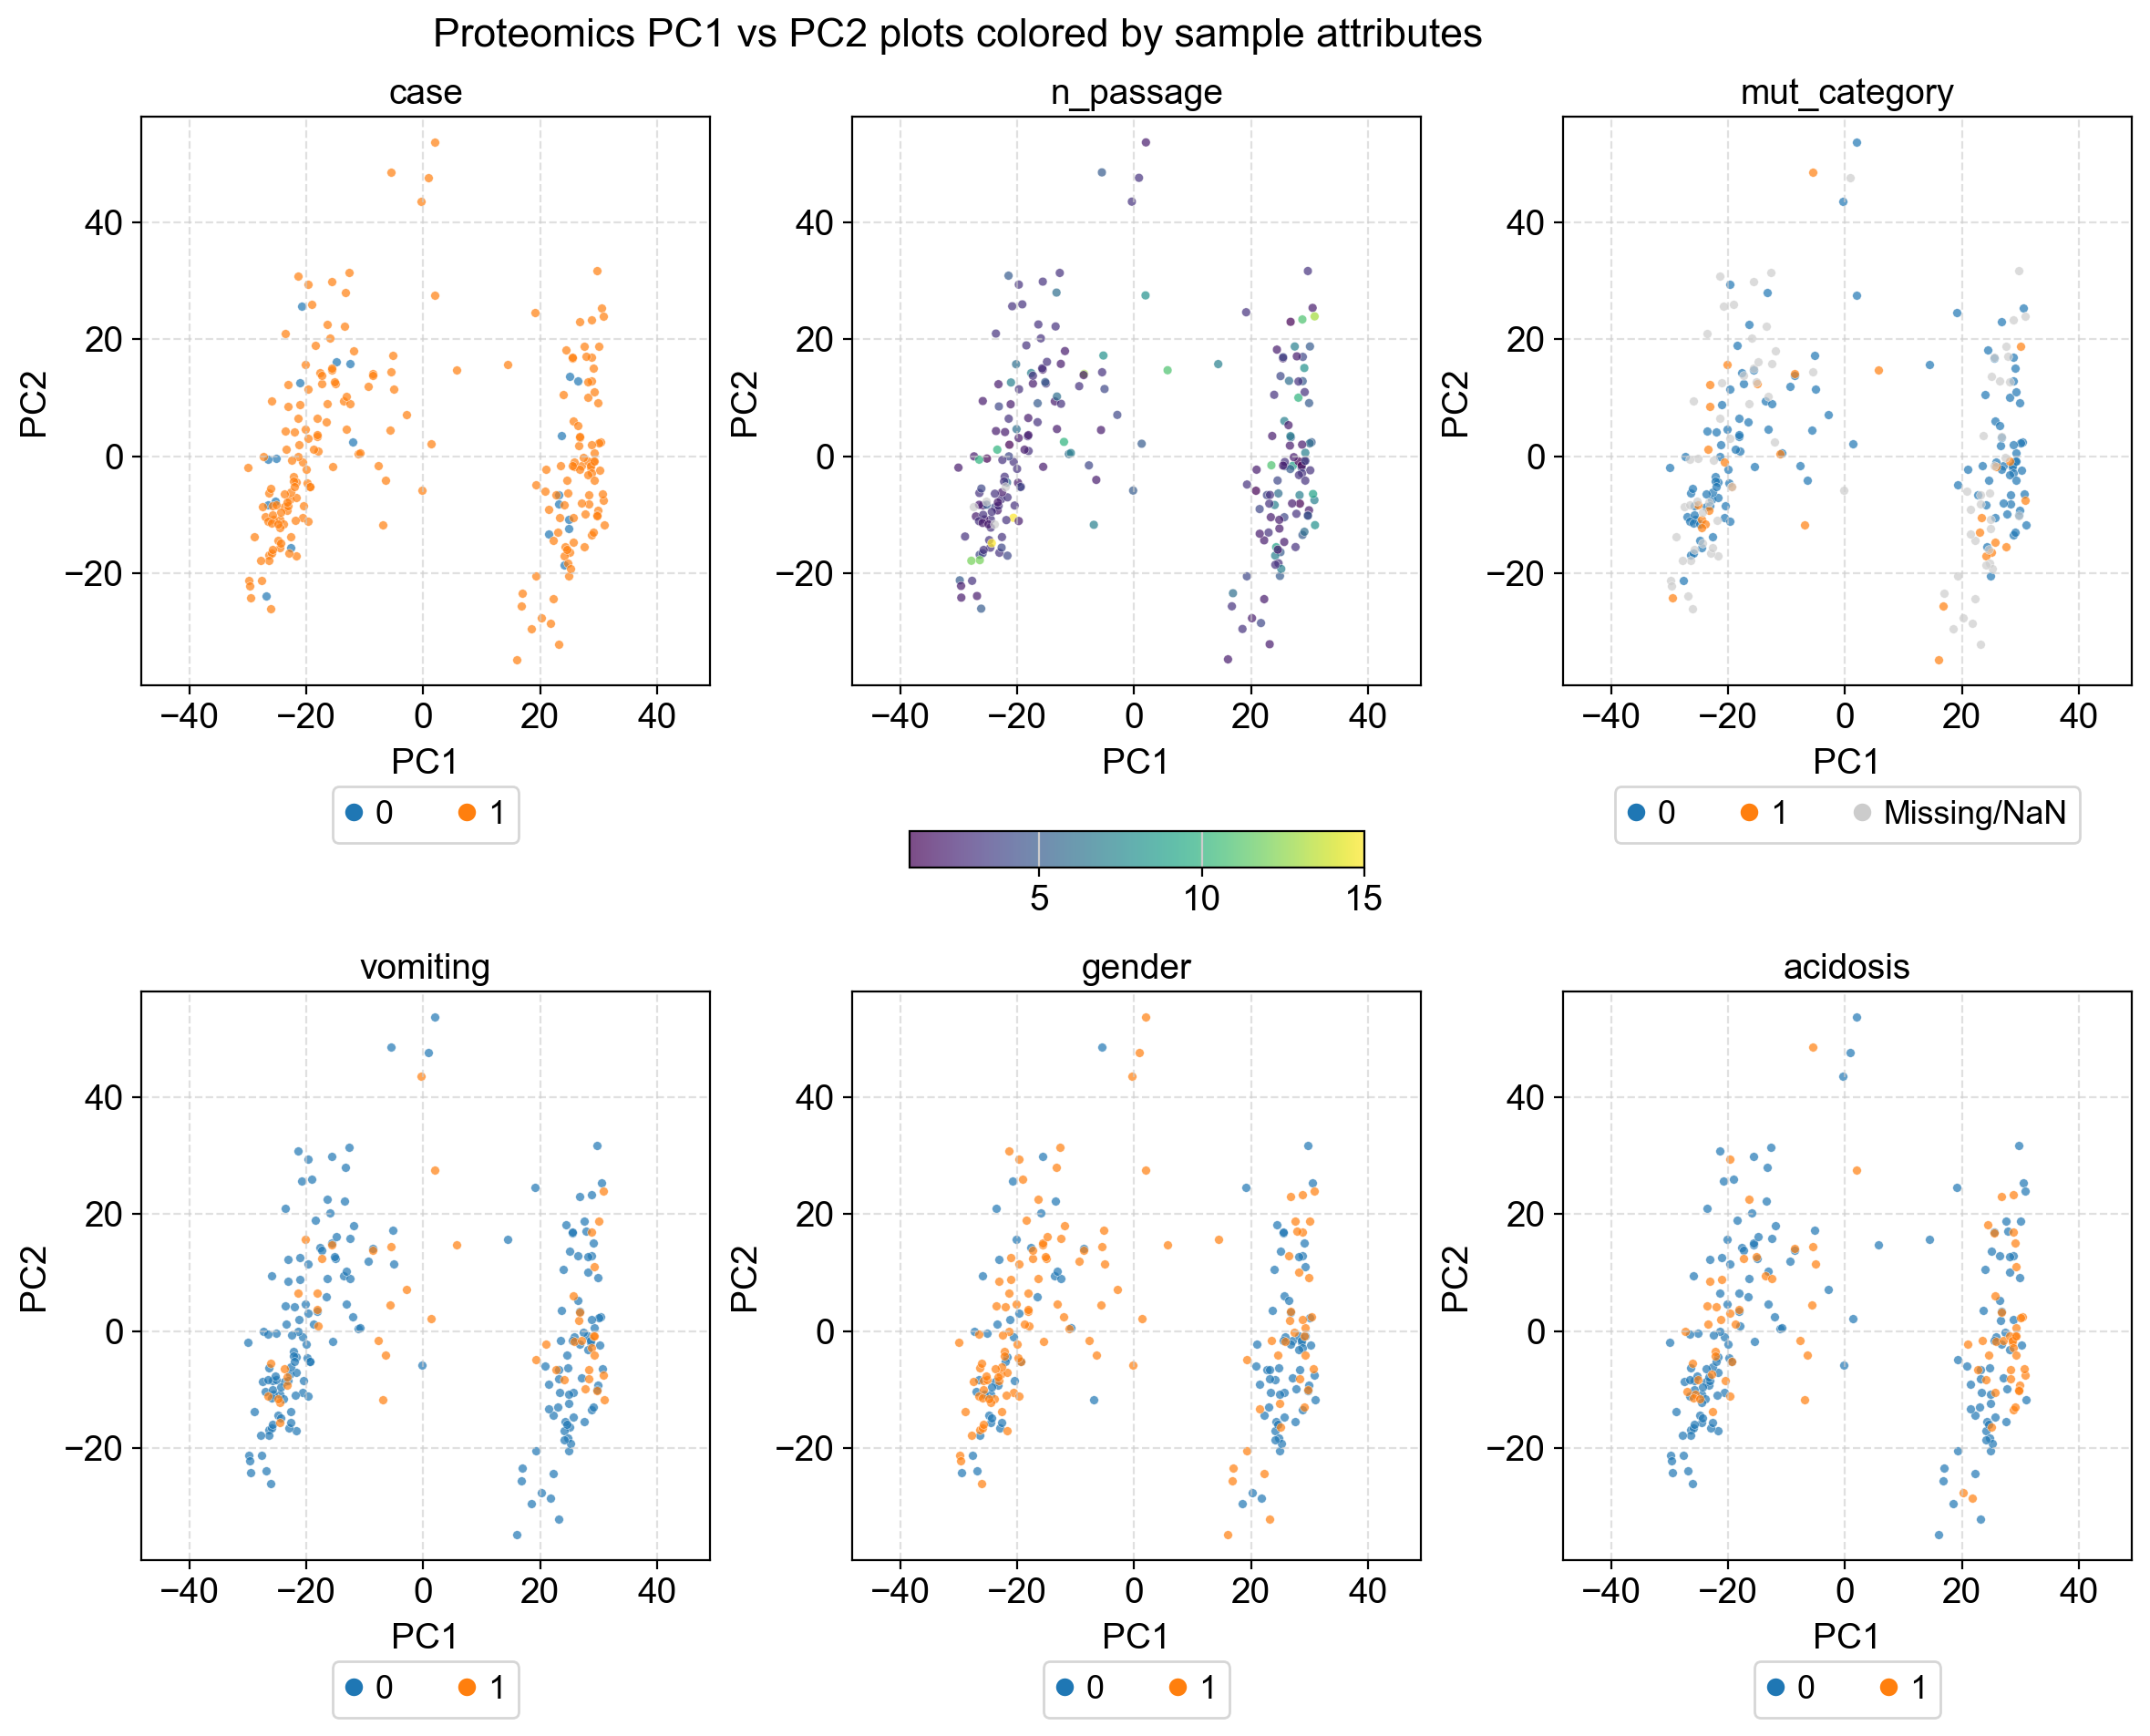

In [20]:
SAMPLE_ATTRIBUTES = ["case", "n_passage", "mut_category","vomiting", "gender", "acidosis"]

eda.plot_mudata_pcs(
    mdata, 
    metadata_attrs=SAMPLE_ATTRIBUTES,
    figsize = (14, 10),
    point_size = 12,
    legend = True
)
plt.show()

Processing transcriptomics modality...
Processing proteomics modality...


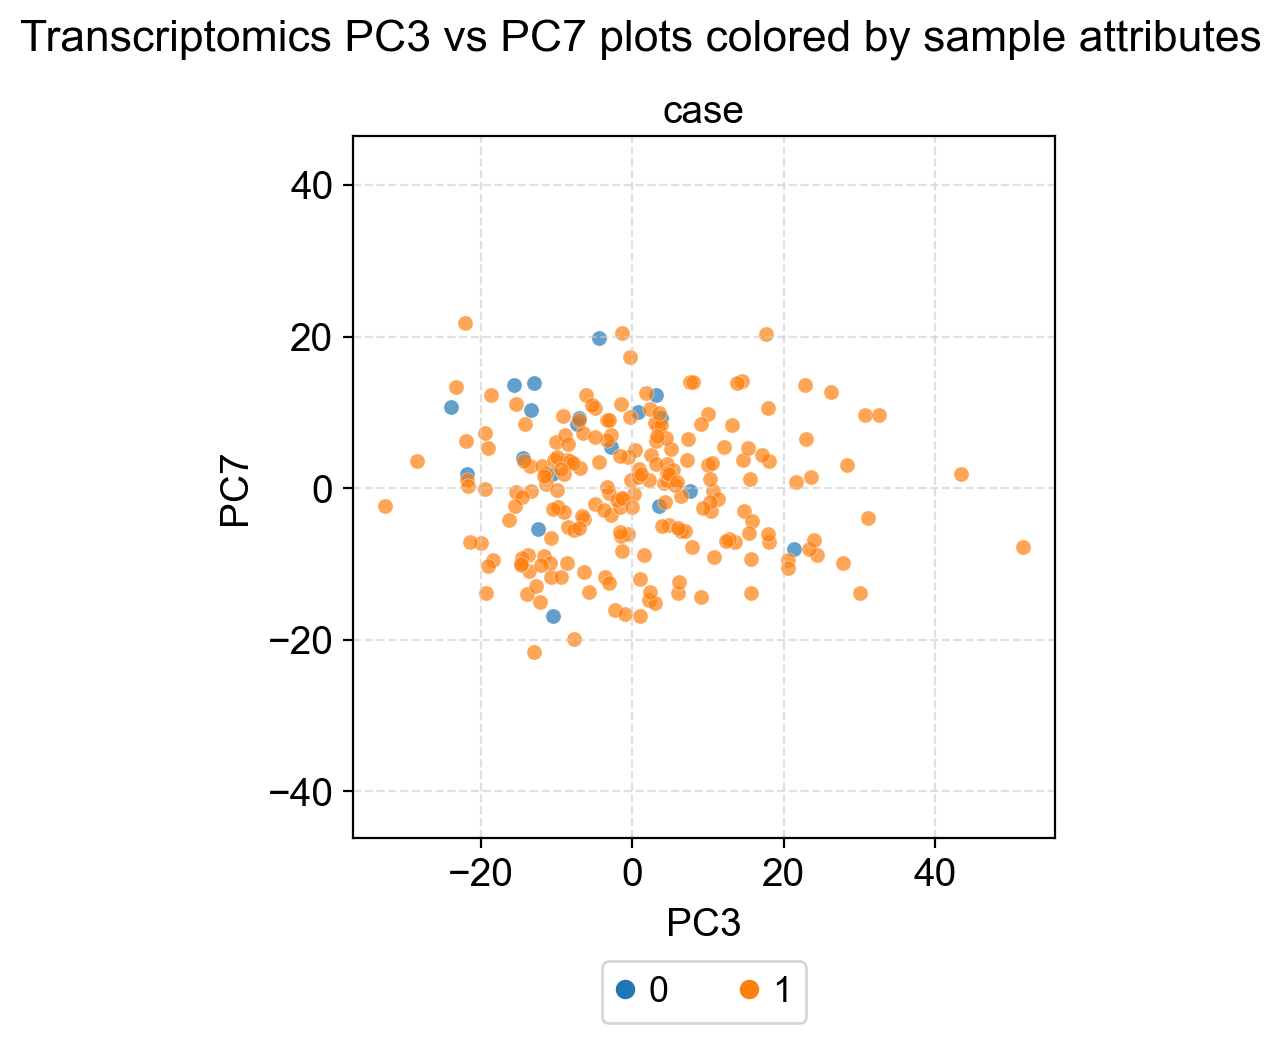

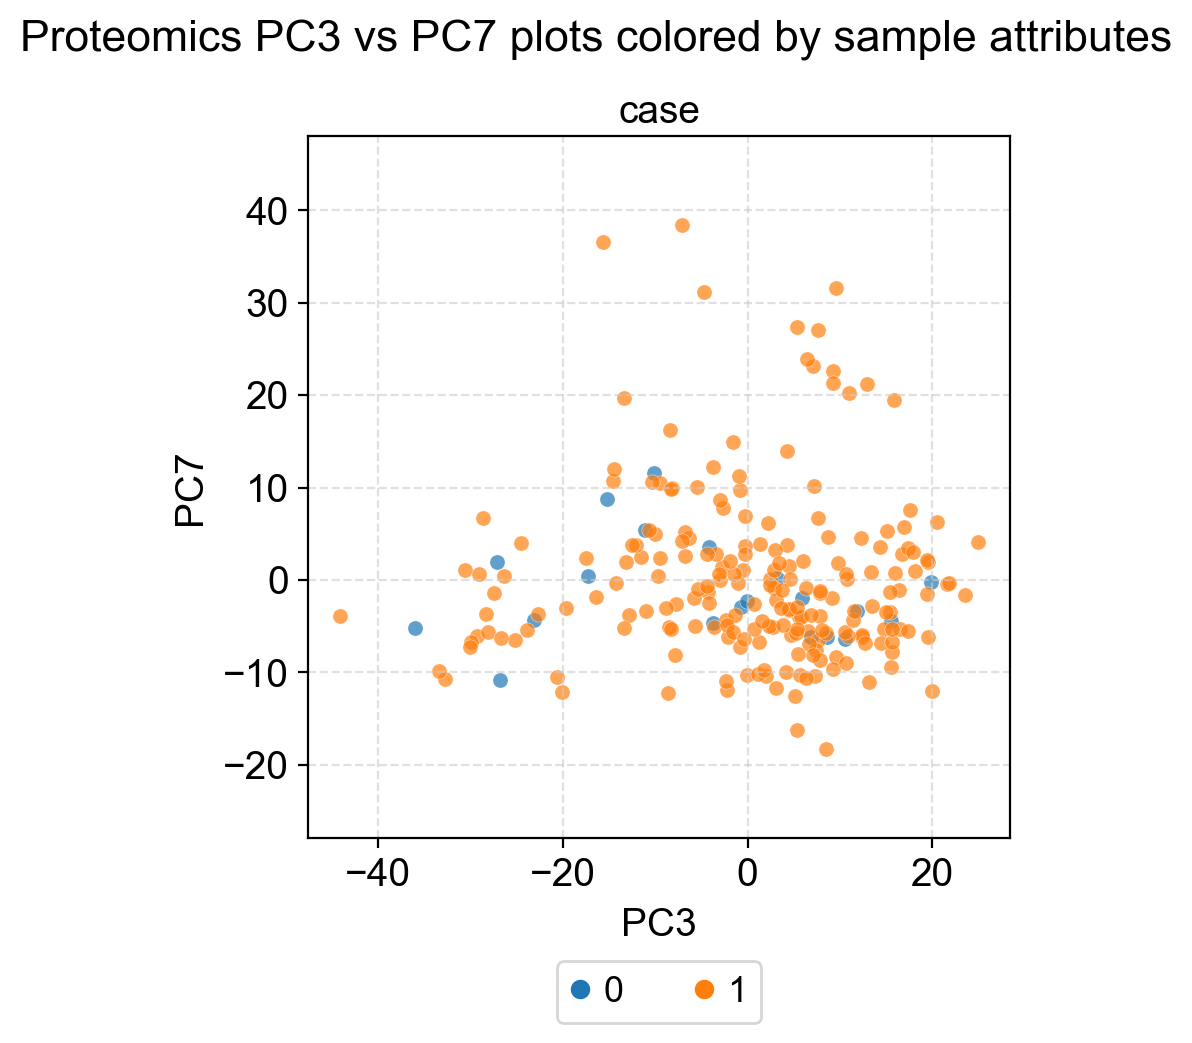

In [21]:
eda.plot_mudata_pcs(mdata, metadata_attrs = "case", pc_x = 3, pc_y = 7)
plt.show()

From the exploratory data analysis we can make a few observations about the dataset(s):

1. From the Screeplot it is clear that there are complex sources of variation in these datasets - from the elbow of the plot, there are likely 8-10 major principal components but even this number only captures 50-60% of the variation in the datasets.
2. The lower fraction of total variation explained in the proteomics than the transcriptomics datasets likely reflect higher technical variation in this dataset.
3. The PC corrplot, and followups plotting pairs of princial components highlight that the the primary attribute of interest, case (i.e, affecteds vs. unaffecteds), is a relatively minor driver of variation in the dataset. It shows up weakly correlated with PC3 in both the transcriptomics' and proteomics' datasets (note that the analysis of each modality is totally separate).
4. PC1 in the proteomics data is bimodal but the two categories do not map onto any of the provided covariates (e.g., gender). Ideally, we'd want to find or define a variable which nicely captures these two groups but I'm not familiar enough with this dataset to do so (I'm guessing its a modest technical batch effect). Unexplained variation of this magnitude is problematic but not a dealbreaker for downstream analyses like regression as it will decrease power and may increase bias depending on the correlation of case or other variables of interest to the latent variable.
5. PC1 in the transcriptomics data is also tricky to understand, there is a rough correlation with the # of passages a cell line has gone through and its mutational status. This may reflect biases in how cell lines are used (preserving those that are particularly precious by putting them through fewer passages) or shifts in the biology of the cell lines as they acclimate to laboratory conditions.

## Generating multi-omic profiles

To map our results onto Napistu network representations we need to generate a set of feature-level summaries. This can be done in multiple ways but for this analysis we'll use a supervised method, differential expression analysis, and an unsupervised one, factor analysis.

### Differential Expression Analysis

I've always done diffex in R, using data modality agnostic methods like regression, and modality-specific methods like DESeq2. It looks like there is a Python implementation of DESeq2 `pydeseq2.dds.DeseqDataSet` but since the transcript counts are not integers this framework is not appropriate. As a result we can just treat the transcripts and proteins equivalently and perform feature-wise regressions to estimate the effect of `case`.

In [22]:
# List of modalities to process
modalities = ["transcriptomics", "proteomics"]  # Add other modalities as needed

# Process each modality
for modality in modalities:
    print(f"Processing {modality}...")
    
    # Skip if modality doesn't exist in the mdata object
    if modality not in mdata.mod:
        print(f"Modality {modality} not found in MuData object. Skipping.")
        continue
    
    # Apply regression per feature
    summaries = profiles.apply_regression_per_feature(
        mdata[modality],
        REGRESSION_FORMULA,
        n_jobs=4,
        layer = ANALYSIS_LAYER,
        progress_bar = False
    )
    
    # Add results to the AnnData object
    profiles.add_regression_results_to_anndata(
        mdata[modality],
        summaries,
        fdr_cutoff=FDR_CUTOFF
    )

Processing transcriptomics...
Starting regression analysis with 4 cores...
Completed regression analysis for 18268 feature-coefficient pairs.
Processing proteomics...
Starting regression analysis with 4 cores...
Completed regression analysis for 9576 feature-coefficient pairs.


Processing transcriptomics...


NameError: name 'kstest' is not defined

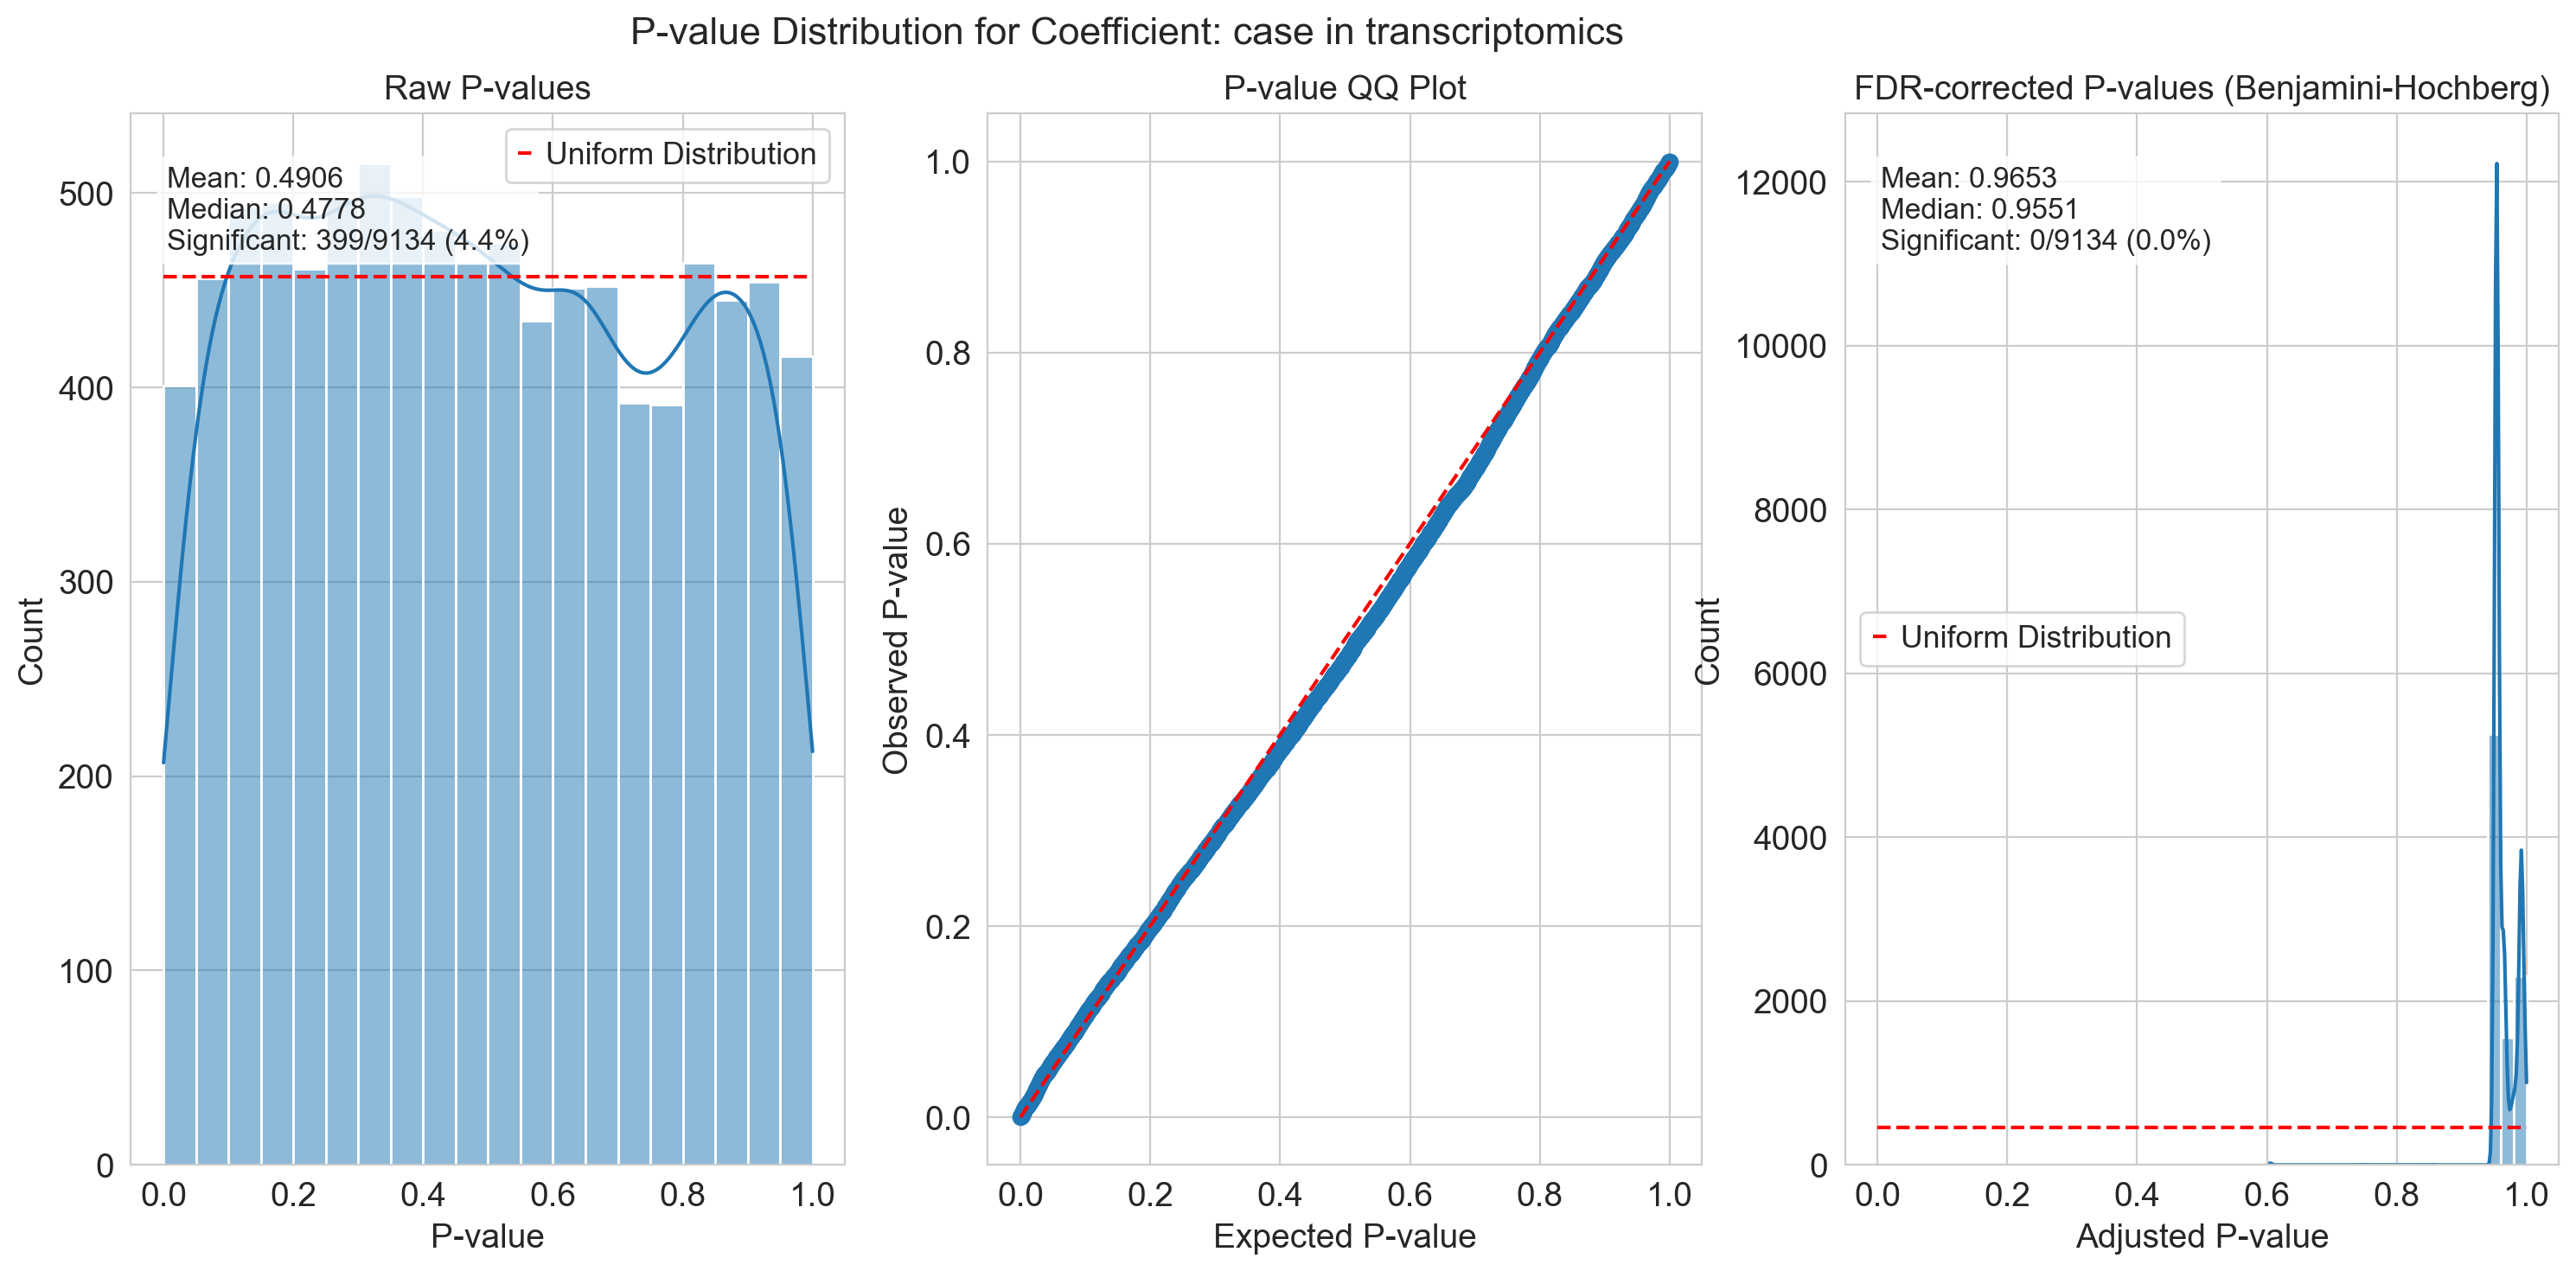

In [23]:
profiles.plot_pvalue_histograms(mdata)
plt.show()

We knew before applying regression analysis that cases were only loosly correlated with the leading PCs and there is also a large case imbalance with only ~12 unaffecteds.

It seems like the signal for `case` is really weak in general so it may not be the right measure for assessing disease biology, relative to a marker of disease severity like `onset_age` or `responsive_to_acute_treatment`.

The p-value histograms for gender show statistical significance in proteomics, and less-significance than expected by chance in the transcriptomics. This suggests confounding (resulting in biased p-values) and/or unaccounted for covariates (as was already expected from EDA).


### Factor Analysis

Since we have two data modalities and we'd like to find patterns of covaration which span both data modalities we can 

In [ ]:
import muon

# update the MuData object so `nvars and `nobs` are appropriate`
intersected_mdata = MuData({k: v for k, v in mdata.mod.items()})

muon.pp.intersect_obs(intersected_mdata)  # This modifies mdata in-place

In [25]:
import muon
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
from functools import reduce


def run_mofa_with_factors(mdata, n_factors, use_layer=None, use_var=None, seed=42, copy=True):
    """
    Run MOFA with a specific number of factors
    
    Parameters
    ----------
    mdata : MuData
        Multi-modal data object
    n_factors : int
        Number of factors to use in MOFA
    use_layer : str, optional
        Layer to use for analysis
    use_var : str, optional
        Variable selection to use
    seed : int, optional
        Random seed for reproducibility
    copy : bool, optional
        Whether to return a copy of the mdata object with MOFA results
        
    Returns
    -------
    mdata_with_mofa : MuData
        MuData object with MOFA results
    """
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Running MOFA with {n_factors} factors...")
    
    # Create a copy if requested
    if copy:
        import mudata as md
        mdata_copy = md.MuData({k: v.copy() for k, v in mdata.mod.items()})
    else:
        mdata_copy = mdata
    
    # Run MOFA (result is stored in the mdata object)
    muon.tl.mofa(
        mdata_copy,
        n_factors=n_factors,
        use_obs=None,  # Assuming observations already intersected
        use_var=use_var,
        use_layer=use_layer,
        seed=seed,
        convergence_mode="fast",  # For faster execution during hyperparameter scan
        verbose=False,
        outfile=False, # don't write to /tmp
        save_metadata=True
    )
    
    return mdata_copy


def evaluate_mofa_model(mdata):
    """
    Calculate evaluation metrics for a MOFA model that's stored in a MuData object
    
    Parameters
    ----------
    mdata : MuData
        Multi-modal data object with trained MOFA results
    
    Returns
    -------
    dict
        Dictionary containing evaluation metrics:
        - total_variance: Sum of variance explained across all modalities and factors
        - modality_variance: Dict mapping modality names to total variance explained in that modality
        - per_factor_variance: Array of variance explained by each factor (summed across modalities)
        - factor_view_variance: Dict mapping modality names to arrays of variance explained by each factor
    """
    # Check if MOFA results exist in the MuData object
    if 'mofa' not in mdata.uns:
        raise ValueError("No MOFA results found in mdata.uns['mofa']. Has MOFA been run on this object?")
    
    # Get MOFA results
    mofa_data = mdata.uns['mofa']
    
    # Check if variance data is available
    if 'variance' not in mofa_data:
        print("No variance data found in MOFA results")
        return {
            'total_variance': None,
            'modality_variance': None,
            'per_factor_variance': None,
            'factor_view_variance': None
        }
    
    # Get variance data for each modality
    variance_data = mofa_data['variance']
    
    # Calculate total variance explained per modality
    # (Sum of variance explained by all factors in each modality)
    modality_variance = {}
    for mod, var_array in variance_data.items():
        modality_variance[mod] = np.sum(var_array)
    
    # Calculate total variance across all modalities
    # (Sum of all explained variance)
    total_variance = sum(modality_variance.values())
    
    # Calculate per-factor variance (summed across modalities)
    # (How much variance each factor explains across all modalities)
    per_factor_variance = None
    n_factors = None
    
    for mod, var_array in variance_data.items():
        if n_factors is None:
            n_factors = len(var_array)
            per_factor_variance = np.zeros(n_factors)
        per_factor_variance += var_array
    
    # Store factor-view variance (how much each factor explains in each modality)
    factor_view_variance = {}
    for mod, var_array in variance_data.items():
        factor_view_variance[mod] = var_array
    
    # Return all metrics
    return {
        'total_variance': total_variance,
        'modality_variance': modality_variance,
        'per_factor_variance': per_factor_variance,
        'factor_view_variance': factor_view_variance
    }


def mofa_factor_scan(mdata, factor_range=range(5, 51, 5), use_layer=None, use_var=None, seed=42):
    """
    Scan different numbers of factors and evaluate MOFA performance
    
    Parameters
    ----------
    mdata : MuData
        Multi-modal data object
    factor_range : iterable
        Range of factors to test
    use_layer : str, optional
        Layer to use for analysis
    use_var : str, optional
        Variable selection to use
    seed : int, optional
        Random seed for reproducibility
    
    Returns
    -------
    dict
        Results for each factor value tested
    """
    results = {}
    
    for n_factors in factor_range:
        try:
            # Create a copy of mdata
            import mudata as md
            mdata_copy = md.MuData({k: v.copy() for k, v in mdata.mod.items()})
            
            # Run MOFA - this will store results in mdata_copy
            mdata_with_mofa = run_mofa_with_factors(mdata_copy, n_factors, use_layer, use_var, seed, copy=False)
            
            # Evaluate
            metrics = evaluate_mofa_model(mdata_with_mofa)
            
            # Store results
            results[n_factors] = {
                'mdata': mdata_with_mofa,
                'metrics': metrics
            }
            
            # Print progress with variance explained if available
            if metrics['total_variance'] is not None:
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Completed {n_factors} factors. "
                      f"Total variance explained: {metrics['total_variance']:.4f}")
            else:
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Completed {n_factors} factors.")
            
        except Exception as e:
            print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Error with {n_factors} factors: {str(e)}")
    
    return results


def visualize_factor_scan(factor_results):
    """
    Visualize the results of the factor scan
    
    Parameters
    ----------
    factor_results : dict
        Results from mofa_factor_scan function
    
    Returns
    -------
    dict
        Dictionary of created figures
    """
    figures = {}
    
    # Extract data
    factors = sorted(list(factor_results.keys()))
    variance = [r['metrics']['total_variance'] for r in factor_results.values() 
                if r['metrics']['total_variance'] is not None]
    
    # Skip visualization if no valid variance data
    if not variance or len(variance) != len(factors):
        print("Warning: Missing variance explained data for some or all factors. Cannot create visualizations.")
        return {}
    
    # 1. Total variance explained plot
    fig1 = plt.figure(figsize=(10, 6))
    plt.plot(factors, variance, 'o-', linewidth=2, color='blue')
    plt.xlabel('Number of factors')
    plt.ylabel('Total variance explained')
    plt.title('MOFA performance vs. number of factors')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    figures['total_variance'] = fig1
    
    # 2. Elbow plot - marginal improvement
    fig2 = plt.figure(figsize=(10, 6))
    if len(factors) > 1:
        # Calculate differences - approximation of "elbow"
        diffs = np.diff(variance)
        diffs = np.append(diffs, diffs[-1])  # Pad to match length
        plt.bar(factors, diffs, color='green', alpha=0.7)
        plt.axhline(y=np.mean(diffs)/2, color='red', linestyle='--', 
                   label=f'Half of mean improvement ({np.mean(diffs)/2:.4f})')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Need at least 2 factor values to calculate marginal improvement',
                horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    
    plt.xlabel('Number of factors')
    plt.ylabel('Marginal variance explained')
    plt.title('Marginal improvement per additional factor')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    figures['elbow'] = fig2
    
    # 3. Per-modality variance - collect data from all factor runs
    fig3 = plt.figure(figsize=(12, 7))
    
    # Gather modality data
    mod_data = []
    for n_factors in factors:
        if factor_results[n_factors]['metrics']['modality_variance']:
            mod_vars = factor_results[n_factors]['metrics']['modality_variance']
            for mod, var in mod_vars.items():
                if var is not None:
                    mod_data.append({'factors': n_factors, 'modality': mod, 'variance': var})
    
    if mod_data:
        mod_df = pd.DataFrame(mod_data)
        
        # Plot modality-specific variances
        sns.lineplot(data=mod_df, x='factors', y='variance', hue='modality', marker='o')
        plt.xlabel('Number of factors')
        plt.ylabel('Variance explained')
        plt.title('Modality-specific variance explained')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
    else:
        plt.text(0.5, 0.5, 'No modality-specific variance data available',
                horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    
    figures['modality_variance'] = fig3
    
    # 4. Factor importance distribution - get per-factor variance 
    if len(factors) > 0:
        # Select a few representative factor values to plot
        if len(factors) <= 4:
            selected_factors = factors
        else:
            # Select min, max, and a couple in between
            q_indices = np.linspace(0, len(factors)-1, 4).astype(int)
            selected_factors = [factors[i] for i in q_indices]
        
        fig4 = plt.figure(figsize=(12, 8))
        plot_count = 0
        
        for i, n_factors in enumerate(selected_factors):
            if 'per_factor_variance' in factor_results[n_factors]['metrics'] and \
               factor_results[n_factors]['metrics']['per_factor_variance'] is not None:
                
                factor_var = factor_results[n_factors]['metrics']['per_factor_variance']
                
                # Ensure we have data
                if len(factor_var) > 0:
                    plot_count += 1
                    plt.subplot(2, 2, plot_count)
                    plt.bar(range(1, len(factor_var)+1), factor_var, color='purple', alpha=0.7)
                    plt.title(f'Factor importance: {n_factors} factors')
                    plt.xlabel('Factor index')
                    plt.ylabel('Variance explained')
                    plt.grid(True, alpha=0.3)
        
        if plot_count > 0:
            plt.tight_layout()
            figures['factor_importance'] = fig4
        else:
            plt.close(fig4)
    
    # 5. Optional: Heatmap of factor-view variance contribution
    for n_factors in [max(factors)]:  # Just use the max factors run for this visualization
        if 'factor_view_variance' in factor_results[n_factors]['metrics'] and \
           factor_results[n_factors]['metrics']['factor_view_variance'] is not None:
            
            factor_view_var = factor_results[n_factors]['metrics']['factor_view_variance']
            if factor_view_var:
                fig5 = plt.figure(figsize=(12, 8))
                
                # Convert to DataFrame for easier plotting
                df_data = []
                for view, factors_var in factor_view_var.items():
                    for f_idx, var in enumerate(factors_var):
                        df_data.append({'View': view, 'Factor': f_idx+1, 'Variance': var})
                
                if df_data:
                    df = pd.DataFrame(df_data)
                    pivot_df = df.pivot(index='View', columns='Factor', values='Variance')
                    
                    # Plot heatmap
                    sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f')
                    plt.title(f'Variance explained per factor per view ({n_factors} factors)')
                    plt.tight_layout()
                    figures['factor_view_heatmap'] = fig5
                else:
                    plt.close(fig5)
    
    return figures


def visualize_factor(mdata_with_mofa, factor_idx, top_n=20, color_by=None, continuous_cmap='viridis'):
    """
    Visualize a specific MOFA factor - its weights and sample distribution
    
    Parameters
    ----------
    mdata_with_mofa : MuData
        MuData object with MOFA results
    factor_idx : int
        Index of the factor to visualize (0-based)
    top_n : int, optional
        Number of top features to show
    color_by : str, optional
        Observation column to color the scatter plot by
    continuous_cmap : str, optional
        Colormap to use for continuous variables
        
    Returns
    -------
    dict
        Dictionary of created figures
    """
    # Ensure MOFA model exists
    if 'mofa' not in mdata_with_mofa.uns:
        raise ValueError("No MOFA results found in mdata_with_mofa.uns['mofa']")
    
    if 'X_mofa' not in mdata_with_mofa.obsm:
        raise ValueError("No factor loadings found in mdata_with_mofa.obsm['X_mofa']")
    
    # Get total number of factors
    n_factors = mdata_with_mofa.obsm['X_mofa'].shape[1]
    
    if factor_idx >= n_factors:
        raise ValueError(f"Factor index {factor_idx} out of range (0-{n_factors-1})")
    
    # For display, use 1-based factor index
    factor_num = factor_idx + 1
    
    figures = {}
    
    # 1. Get factor scores for all samples
    factor_scores = mdata_with_mofa.obsm['X_mofa'][:, factor_idx]
    
    # 2. Plot distribution of factor scores
    fig1 = plt.figure(figsize=(12, 6))
    
    # Use different coloring if requested
    if color_by is not None and color_by in mdata_with_mofa.obs.columns:
        color_values = mdata_with_mofa.obs[color_by]
        
        # Check if categorical or continuous
        if pd.api.types.is_categorical_dtype(color_values) or pd.api.types.is_object_dtype(color_values):
            # Categorical coloring
            for category in color_values.unique():
                subset = factor_scores[color_values == category]
                plt.hist(subset, alpha=0.6, label=str(category), bins=20)
            plt.legend()
        else:
            # Continuous coloring with scatter
            plt.scatter(range(len(factor_scores)), 
                       np.sort(factor_scores), 
                       c=color_values.values[np.argsort(factor_scores)],
                       cmap=continuous_cmap)
            plt.colorbar(label=color_by)
    else:
        # Default histogram
        plt.hist(factor_scores, bins=30, alpha=0.7)
    
    plt.xlabel(f'Factor {factor_num} score')
    plt.ylabel('Count')
    plt.title(f'Distribution of Factor {factor_num} scores')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    figures['factor_distribution'] = fig1
    
    # 3. Top weights for each modality
    for mod_idx, (mod_name, mod) in enumerate(mdata_with_mofa.mod.items()):
        if 'LFs' in mod.varm:
            weights = mod.varm['LFs'][:, factor_idx]
            
            # Get top positive and negative features
            top_pos_idx = np.argsort(-weights)[:top_n]
            top_neg_idx = np.argsort(weights)[:top_n]
            
            # Create figures for top features
            fig_pos = plt.figure(figsize=(10, 8))
            plt.barh(np.arange(len(top_pos_idx)), weights[top_pos_idx], color='green', alpha=0.7)
            plt.yticks(np.arange(len(top_pos_idx)), mod.var_names[top_pos_idx])
            plt.xlabel('Weight')
            plt.title(f'Top {top_n} positive features for Factor {factor_num} in {mod_name}')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            figures[f'{mod_name}_top_positive'] = fig_pos
            
            fig_neg = plt.figure(figsize=(10, 8))
            plt.barh(np.arange(len(top_neg_idx)), weights[top_neg_idx], color='red', alpha=0.7)
            plt.yticks(np.arange(len(top_neg_idx)), mod.var_names[top_neg_idx])
            plt.xlabel('Weight')
            plt.title(f'Top {top_n} negative features for Factor {factor_num} in {mod_name}')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            figures[f'{mod_name}_top_negative'] = fig_neg
    
    # 4. Scatter plots of this factor vs all other factors
    scatter_figs = plt.figure(figsize=(15, 15))
    n_rows = (n_factors - 1) // 3 + 1
    n_cols = min(n_factors - 1, 3)
    
    for i in range(n_factors):
        if i == factor_idx:
            continue
        
        plot_idx = i if i < factor_idx else i - 1
        plt.subplot(n_rows, n_cols, plot_idx + 1)
        
        # Color if requested
        if color_by is not None and color_by in mdata_with_mofa.obs.columns:
            color_values = mdata_with_mofa.obs[color_by]
            
            # Check if categorical or continuous
            if pd.api.types.is_categorical_dtype(color_values) or pd.api.types.is_object_dtype(color_values):
                # Categorical coloring
                for category in color_values.unique():
                    mask = color_values == category
                    plt.scatter(factor_scores[mask], 
                               mdata_with_mofa.obsm['X_mofa'][mask, i], 
                               alpha=0.7, 
                               label=str(category))
                if plot_idx == 0:
                    plt.legend()
            else:
                # Continuous coloring
                sc = plt.scatter(factor_scores, 
                                mdata_with_mofa.obsm['X_mofa'][:, i], 
                                c=color_values.values,
                                cmap=continuous_cmap,
                                alpha=0.7)
                if plot_idx == 0:
                    plt.colorbar(sc, label=color_by)
        else:
            plt.scatter(factor_scores, mdata_with_mofa.obsm['X_mofa'][:, i], alpha=0.7)
        
        plt.xlabel(f'Factor {factor_num}')
        plt.ylabel(f'Factor {i+1}')
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    figures['factor_scatter_plots'] = scatter_figs
    
    return figures


def determine_optimal_factors(factor_results, criterion='elbow', threshold=0.01):
    """
    Automatically determine the optimal number of factors based on specified criteria
    
    Parameters
    ----------
    factor_results : dict
        Results from mofa_factor_scan function
    criterion : str
        Method to use for determining optimal factors ('elbow', 'threshold', or 'balanced')
    threshold : float
        Threshold for marginal improvement (used if criterion='threshold')
    
    Returns
    -------
    int
        Optimal number of factors
    """
    factors = sorted(list(factor_results.keys()))
    variance = [r['metrics']['total_variance'] for r in factor_results.values() 
                if r['metrics']['total_variance'] is not None]
    
    # Check if we have valid variance data
    if not variance or len(variance) != len(factors):
        print("Warning: Missing variance explained data for some or all factors. Cannot determine optimal factors.")
        return None
        
    if len(factors) <= 1:
        return factors[0] if factors else None
    
    # Calculate marginal improvements
    diffs = np.diff(variance)
    
    if criterion == 'elbow':
        # Elbow method: find where the rate of change of the differences is greatest
        # (approximating the second derivative)
        if len(diffs) <= 1:
            return factors[0]
            
        # Calculate the acceleration (approximating second derivative)
        acceleration = np.diff(diffs)
        acceleration = np.append(acceleration, acceleration[-1])  # Pad to match length
        
        # Find the point of maximum acceleration
        elbow_idx = np.argmax(np.abs(acceleration)) + 1  # +1 because we're working with diffs
        
        return factors[elbow_idx]
        
    elif criterion == 'threshold':
        # Threshold method: find first point where marginal improvement falls below threshold
        for i, diff in enumerate(diffs):
            if diff < threshold:
                return factors[i]
        
        # If all improvements are above threshold, return the maximum
        return factors[-1]
        
    elif criterion == 'balanced':
        # Balanced approach: consider both variance explained and number of factors
        
        # Normalize factors and variance to [0, 1]
        norm_factors = (np.array(factors) - min(factors)) / (max(factors) - min(factors))
        norm_variance = (np.array(variance) - min(variance)) / (max(variance) - min(variance))
        
        # Calculate a score balancing parsimony and variance explained
        # Higher variance is better, fewer factors is better
        scores = norm_variance - 0.5 * norm_factors
        
        # Find the factor value with the highest score
        best_idx = np.argmax(scores)
        
        return factors[best_idx]
    
    else:
        raise ValueError(f"Unknown criterion: {criterion}. Use 'elbow', 'threshold', or 'balanced'.")


def run_complete_factor_scan(mdata, factor_range=range(5, 51, 5), use_layer=None, use_var=None, 
                           criterion='elbow', threshold=0.01, seed=42):
    """
    Complete workflow: runs factor scan, visualizes results, and determines optimal number of factors
    
    Parameters
    ----------
    mdata : MuData
        Multi-modal data object
    factor_range : iterable
        Range of factors to test
    use_layer : str, optional
        Layer to use for analysis
    use_var : str, optional
        Variable selection to use
    criterion : str
        Method to determine optimal factors ('elbow', 'threshold', or 'balanced')
    threshold : float
        Threshold for marginal improvement
    seed : int
        Random seed for reproducibility
    
    Returns
    -------
    dict
        Complete results including optimal factors and final model
    """
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Starting MOFA factor scan...")
    
    # Step 1: Run the scan
    factor_results = mofa_factor_scan(mdata, factor_range, use_layer, use_var, seed)
    
    # Step 2: Visualize results
    figures = visualize_factor_scan(factor_results)
    
    # Step 3: Determine optimal number of factors
    optimal_factors = determine_optimal_factors(factor_results, criterion, threshold)
    
    if optimal_factors is None:
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Could not determine optimal factors. Please check scan results.")
        return {
            'factor_results': factor_results,
            'figures': figures,
            'optimal_factors': None,
            'final_mdata': None,
            'final_model_status': "could not determine optimal factors"
        }
    
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Optimal number of factors: {optimal_factors}")
    
    # Step 4: Run final model with optimal factors (with better convergence)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Training final model with {optimal_factors} factors...")
    
    try:
        # Create a fresh copy for the final model
        import mudata as md
        final_mdata = md.MuData({k: v.copy() for k, v in mdata.mod.items()})
        
        # Run MOFA with optimal factors and better convergence
        muon.tl.mofa(
            final_mdata,
            n_factors=optimal_factors,
            use_obs=None,
            use_var=use_var,
            use_layer=use_layer,
            seed=seed,
            verbose=True,
            convergence_mode="medium"  # Use better convergence for final model
        )
        
        # Extract factors and weights
        muon.tl.mofa_extract_weights(final_mdata)
        muon.tl.mofa_extract_factors(final_mdata)
        
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Final model trained successfully.")
        final_model_status = "success"
    except Exception as e:
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Error training final model: {str(e)}")
        final_mdata = None
        final_model_status = f"error: {str(e)}"
    
    # Return comprehensive results
    return {
        'factor_results': factor_results,
        'figures': figures,
        'optimal_factors': optimal_factors,
        'final_mdata': final_mdata,
        'final_model_status': final_model_status
    }


def analyze_optimal_mofa_model(mdata_with_mofa, top_n=20, plot_factors=True):
    """
    Analyze a MOFA model with optimal number of factors
    
    Parameters
    ----------
    mdata_with_mofa : MuData
        MuData object with MOFA results
    top_n : int, optional
        Number of top features to show per factor
    plot_factors : bool, optional
        Whether to plot factor scatter plots
        
    Returns
    -------
    dict
        Analysis results
    """
    # 1. Check if MOFA has been run
    if 'mofa' not in mdata_with_mofa.uns:
        raise ValueError("No MOFA results found in mdata_with_mofa.uns['mofa']")
    
    if 'X_mofa' not in mdata_with_mofa.obsm:
        raise ValueError("No factor loadings found in mdata_with_mofa.obsm['X_mofa']")
    
    # 2. Extract key information
    mofa_data = mdata_with_mofa.uns['mofa']
    n_factors = mdata_with_mofa.obsm['X_mofa'].shape[1]
    factors = mdata_with_mofa.obsm['X_mofa']
    
    # Print MOFA parameters
    if 'params' in mofa_data:
        print("MOFA Parameters:")
        print(f"  Number of factors: {mofa_data['params']['model']['n_factors']}")
        print(f"  Likelihoods: {mofa_data['params']['data']['likelihoods']}")
        print(f"  Layer used: {mofa_data['params']['data']['use_layer']}")
        print(f"  ARD factors: {mofa_data['params']['model']['ard_factors']}")
        print(f"  ARD weights: {mofa_data['params']['model']['ard_weights']}")
        print(f"  Spikeslab weights: {mofa_data['params']['model']['spikeslab_weights']}")
        print(f"  Convergence mode: {mofa_data['params']['training']['convergence_mode']}")
        print(f"  Iterations: {mofa_data['params']['training']['n_iterations']}")
    
    # 3. Variance explained
    variance_info = evaluate_mofa_model(mdata_with_mofa)
    
    # Print variance summary
    print("\nVariance Explained Summary:")
    if variance_info['total_variance'] is not None:
        print(f"  Total variance explained: {variance_info['total_variance']:.2f}")
        
        for mod, var in variance_info['modality_variance'].items():
            print(f"  {mod}: {var:.2f}")
    
    # 4. Get top features for each factor from weights in varm
    top_features = {}
    for mod_name, mod in mdata_with_mofa.mod.items():
        if 'LFs' in mod.varm:
            weights = mod.varm['LFs']
            top_features[mod_name] = {}
            
            for factor_idx in range(n_factors):
                factor_weights = weights[:, factor_idx]
                
                # Get top positive and negative influences
                top_pos_idx = np.argsort(-factor_weights)[:top_n]
                top_neg_idx = np.argsort(factor_weights)[:top_n]
                
                top_features[mod_name][f'Factor_{factor_idx+1}_positive'] = mod.var_names[top_pos_idx].tolist()
                top_features[mod_name][f'Factor_{factor_idx+1}_negative'] = mod.var_names[top_neg_idx].tolist()
    
    # 5. Visualize factors
    factor_plots = {}
    
    # 5.1 Factor scatter plot matrix
    if plot_factors and n_factors > 1:
        fig, axes = plt.subplots(n_factors-1, n_factors-1, figsize=(15, 15))
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        
        for i in range(n_factors-1):
            for j in range(i+1, n_factors):
                # Find the correct subplot position
                if n_factors > 2:
                    ax = axes[i, j-1] if i < axes.shape[0] and j-1 < axes.shape[1] else None
                else:
                    ax = axes
                
                if ax is not None:
                    sc = ax.scatter(factors[:, i], factors[:, j], alpha=0.7)
                    ax.set_xlabel(f'Factor {i+1}')
                    ax.set_ylabel(f'Factor {j+1}')
                    ax.grid(alpha=0.3)
        
        plt.tight_layout()
        factor_plots['factor_scatter_matrix'] = fig
    
    # 5.2 PCA of factors
    if plot_factors and n_factors > 2:
        from sklearn.decomposition import PCA
        
        # Apply PCA to reduce factors to 2D for visualization
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(factors)
        
        fig = plt.figure(figsize=(10, 8))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title('PCA of MOFA factors')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        
        factor_plots['factor_pca'] = fig
    
    # 5.3 Variance explained per factor
    if 'per_factor_variance' in variance_info and variance_info['per_factor_variance'] is not None:
        fig = plt.figure(figsize=(12, 6))
        
        # Plot variance per factor
        factor_var = variance_info['per_factor_variance']
        plt.bar(range(1, len(factor_var)+1), factor_var, color='blue', alpha=0.7)
        plt.xlabel('Factor')
        plt.ylabel('Variance explained')
        plt.title('Variance explained per factor')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        factor_plots['variance_per_factor'] = fig
    
    # 5.4 Variance explained per factor per modality
    if 'factor_view_variance' in variance_info and variance_info['factor_view_variance'] is not None:
        # Create a multi-bar chart showing variance per factor per modality
        fig = plt.figure(figsize=(14, 8))
        
        factor_indices = np.arange(1, n_factors+1)
        bar_width = 0.8 / len(variance_info['factor_view_variance'])
        
        # Plot bars for each modality
        for i, (mod_name, variance) in enumerate(variance_info['factor_view_variance'].items()):
            offset = (i - len(variance_info['factor_view_variance'])/2 + 0.5) * bar_width
            plt.bar(factor_indices + offset, variance, 
                   width=bar_width, 
                   alpha=0.7, 
                   label=mod_name)
        
        plt.xlabel('Factor')
        plt.ylabel('Variance explained')
        plt.title('Variance explained per factor per modality')
        plt.xticks(factor_indices)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        factor_plots['variance_per_factor_per_modality'] = fig
        
        # Add heatmap visualization if there are multiple modalities
        if len(variance_info['factor_view_variance']) > 1:
            fig2 = plt.figure(figsize=(10, 6))
            
            # Create a matrix for the heatmap
            data = []
            mod_names = []
            
            for mod_name, var_array in variance_info['factor_view_variance'].items():
                data.append(var_array)
                mod_names.append(mod_name)
                
            data_matrix = np.array(data)
            
            # Plot heatmap
            im = plt.imshow(data_matrix, cmap='viridis')
            plt.colorbar(im, label='Variance explained')
            plt.xticks(np.arange(n_factors), labels=[f'F{i+1}' for i in range(n_factors)])
            plt.yticks(np.arange(len(mod_names)), labels=mod_names)
            plt.xlabel('Factors')
            plt.ylabel('Modalities')
            plt.title('Variance explained by each factor in each modality')
            
            # Add text annotations
            for i in range(len(mod_names)):
                for j in range(n_factors):
                    text = plt.text(j, i, f'{data_matrix[i, j]:.2f}',
                                  ha="center", va="center", color="white" if data_matrix[i, j] > np.max(data_matrix)/2 else "black")
            
            plt.tight_layout()
            factor_plots['variance_heatmap'] = fig2
    
    # Return all analysis results
    return {
        'n_factors': n_factors,
        'variance_info': variance_info,
        'top_features': top_features,
        'factor_plots': factor_plots
    }

In [ ]:
import mudata as md
import json

# ==============================================
# Step 1: Run the hyperparameter sweep (1 hour)
# ==============================================

# Assuming mdata is already prepared with intersected observations
# and properly filtered features

# Define the range of factors to test
FACTOR_RANGE = range(5, 31, 5)  # Test from 5 to 30 factors in steps of 5

# Define the path to save the results
MOFA_PARAM_SCAN_MODELS_PATH = "/tmp/mofa_param_scan_h5mu"

OVERWRITE = False

# Import the functions from the other module
# (Assuming you've saved the functions in a file called mofa_functions.py)
# from mofa_functions import *

# Or copy the functions directly here if needed
# (Paste the functions here)

def run_mofa_factor_scan(mdata, factor_range=range(5, 31, 5), use_layer="log2_centered", 
                       use_var=None, seed=42, models_dir="mofa_models", overwrite=False):
    """
    Run a MOFA factor scan and save results to disk
    
    Parameters
    ----------
    mdata : MuData
        Multi-modal data object
    factor_range : iterable
        Range of factors to test
    use_layer : str
        Layer to use for analysis
    use_var : str or None
        Variable selection to use
    seed : int
        Random seed for reproducibility
    models_dir : str
        Directory to store model files
    overwrite : bool
        Whether to overwrite existing models and results
    
    Returns
    -------
    dict
        Results dictionary with metrics for each factor value
    """
    # Create directory to store MOFA models
    os.makedirs(models_dir, exist_ok=True)
    
    # Results file path
    results_file = os.path.join(models_dir, "scan_results.json")
    
    # If overwrite is True, delete existing results
    if overwrite and os.path.exists(results_file):
        print(f"Overwrite requested. Removing existing results file: {results_file}")
        os.remove(results_file)
        
        # Also remove existing model files
        for n_factors in factor_range:
            model_file = os.path.join(models_dir, f"mofa_{n_factors}_factors.h5mu")
            if os.path.exists(model_file):
                print(f"Removing existing model file: {model_file}")
                os.remove(model_file)
    
    # Check if we already have results
    if os.path.exists(results_file):
        print(f"Loading cached results from {results_file}")
        with open(results_file, 'r') as f:
            metrics_by_factors = json.load(f)
        
        # Convert string keys back to integers
        metrics_by_factors = {int(k): v for k, v in metrics_by_factors.items()}
        print(f"Loaded metrics for {len(metrics_by_factors)} factor values")
        
        # Reconstruct a basic factor_results structure with metrics
        factor_results = {}
        for n_factors, metrics in metrics_by_factors.items():
            factor_results[n_factors] = {'metrics': metrics}
            
            # Check if the corresponding model file exists
            model_file = os.path.join(models_dir, f"mofa_{n_factors}_factors.h5mu")
            if os.path.exists(model_file):
                print(f"Model file for {n_factors} factors exists")
            else:
                print(f"Warning: Model file for {n_factors} factors is missing")
    else:
        print("Running MOFA factor scan (this may take about an hour)...")
        # Initialize results
        factor_results = {}
        metrics_by_factors = {}
        
        # Run MOFA for each number of factors
        for n_factors in factor_range:
            try:
                model_file = os.path.join(models_dir, f"mofa_{n_factors}_factors.h5mu")
                
                # Skip if model exists and we're not overwriting
                if not overwrite and os.path.exists(model_file):
                    print(f"Model file for {n_factors} factors already exists. Skipping.")
                    try:
                        # Load model to get metrics
                        mdata_copy = md.read(model_file)
                        metrics = evaluate_mofa_model(mdata_copy)
                        factor_results[n_factors] = {'metrics': metrics}
                        metrics_by_factors[n_factors] = metrics
                        continue
                    except Exception as e:
                        print(f"Error loading model: {str(e)}. Will recompute.")
                
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Running MOFA with {n_factors} factors...")
                
                # Create a copy of mdata
                mdata_copy = md.MuData({k: v.copy() for k, v in mdata.mod.items()})
                
                # Run MOFA
                muon.tl.mofa(
                    mdata_copy,
                    n_factors=n_factors,
                    use_obs=None,
                    use_var=use_var,
                    use_layer=use_layer,
                    seed=seed,
                    convergence_mode="fast",
                    verbose=False,
                    save_metadata=True
                )
                
                # Extract factors and weights
                muon.tl.mofa_extract_weights(mdata_copy)
                muon.tl.mofa_extract_factors(mdata_copy)
                
                # Evaluate model
                metrics = evaluate_mofa_model(mdata_copy)
                
                # Store results
                factor_results[n_factors] = {
                    'metrics': metrics
                }
                metrics_by_factors[n_factors] = metrics
                
                # Save model to file
                mdata_copy.write(model_file)
                print(f"Saved model to {model_file}")
                
                # Print progress
                if metrics['total_variance'] is not None:
                    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Completed {n_factors} factors. "
                          f"Total variance explained: {metrics['total_variance']:.4f}")
                else:
                    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Completed {n_factors} factors.")
                    
            except Exception as e:
                print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Error with {n_factors} factors: {str(e)}")
        
        # Save metrics to JSON file
        with open(results_file, 'w') as f:
            json.dump(metrics_by_factors, f, indent=2)
        print(f"Saved metrics to {results_file}")
    
    return factor_results

# Run the factor scan
factor_results = run_mofa_factor_scan(
    mdata, 
    factor_range=FACTOR_RANGE,
    use_layer=ANALYSIS_LAYER,
    use_var=None,  # Adjust if you want to use specific features
    seed=42,
    models_dir=MOFA_PARAM_SCAN_MODELS_PATH,
    overwrite=OVERWRITE
)